In [1]:
import json
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from pyproj import Geod
from shapely.geometry import LineString
import numpy as np
import tempun
import seaborn as sns
import geoplot as gplt

In [2]:
# global parameters for plots
plt.style.use("fast")
plt.rcParams['figure.dpi'] = 600
plt.rcParams['figure.figsize'] = (4.45, 3)
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

def save_figure(fig, fig_name):
    fig.savefig("../figures/" + fig_name + ".tiff", dpi=600)
    fig.savefig("../figures/" + fig_name + ".png", dpi=600)

# Loading data

In [3]:
try:
    GIST = gpd.read_parquet("../../GI_ETL/data/large_data/GIST_v0-2.parquet")
except:
    GIST = gpd.read_parquet("https://zenodo.org/record/7185509/files/GIST_v0-2.parquet?download=1")

In [4]:
GIST["not_before"] = GIST["not_before"].astype(float)
GIST["not_after"] = GIST["not_after"].astype(float)

In [7]:
len(GIST)

217863

In [5]:
GIST["random_dates"] = GIST.apply(lambda row: tempun.model_date(row["not_before"], row["not_after"], size=100), axis=1)

In [11]:
GIST_dated = GIST[(GIST["not_before"].notnull()) | (GIST["not_after"].notnull())]
len(GIST_dated)

131677

In [12]:
ids_list = [str(id) for id in GIST_dated[GIST_dated["random_dates"].apply(lambda x: x[0]).between(-500,-300)]["PHI_ID"]]
len(ids_list)

23800

In [5]:
len(GIST[GIST["not_after"].notnull()])

127984

In [6]:
GIST.shape

(217863, 30)

In [7]:
sum(GIST["clean_text_interpretive_word"].apply(lambda x: len(x.split())))

4459865

In [8]:
pleiades_regions = gpd.read_file("../data/pleiades_regions.geojson", driver="GeoJSON")
Greece = gpd.read_file("../data/Greece_AL2.GeoJson", driver="GeoJSON") # borders of greek downloaded from https://www.kaggle.com/datasets/lsind18/greeceborders?resource=download
Asia_Minor = gpd.read_file("../data/PHI_asia-minor.geojson", driver="GeoJSON")

In [9]:
pleiades_regions = gpd.read_file("../data/pleiades_regions.geojson", driver="GeoJSON")
pleiades_regions = pleiades_regions.to_crs(3035)
pleiades_regions_merged = pleiades_regions.unary_union
pleiades_regions_merged_buffer = pleiades_regions_merged.buffer(distance=2000)

In [10]:
polis = pd.read_csv("../data/polis_database.csv")
polis.head(5)

name  polis_id     xcoord     ycoord edges  Polisity  Hellenicity  \
0       1-Alalie         1   9.511698  42.102432  none       1.0          1.0   
1       10-Akrai        10  14.916667  37.083333  none       3.0          1.0   
2    100-Kassopa       100  20.687268  39.140534  none       1.0          1.0   
3    1000-Rhodos      1000  28.227611  36.443113  none       1.0          1.0   
4  1001-Aspendos      1001  31.170175  36.939091  none       1.0          2.0   

   Fame  In_out  Size  Silver_1st  Bronze_1st  Grid  Colonies  Victors  \
0  1.12     1.0   3.0         NaN         NaN   NaN       0.0      0.0   
1  1.25     2.0   0.0         NaN         NaN   NaN       0.0      0.0   
2  1.37     3.0   5.0         4.0         4.0   4.0       0.0      0.0   
3  7.00     2.0   5.0         5.0         4.0   5.0       3.0      1.0   
4  2.25     2.0   4.0         5.0         4.0   NaN       0.0      0.0   

   Proxenoi  Walls  Delian_League  Koinon  Regime  Region_num  \
0       0.0    1.0            0.0     NaN     0.0         1.0   
1       0.0    1.0            0.0     NaN     0.0         2.0   
2       0.0    1.0            0.0     1.0     0.0         5.0   
3       1.0    1.0            0.0     NaN     2.0        42.0   
4       1.0    1.0            1.0     NaN     0.0        43.0   

           Region name         Source  Elevation_m  
0       Spain & France  HansonNielson         41.7  
1              Sikelia  HansonNielson        604.0  
2              Epeiros  HansonNielson        452.4  
3               Rhodos  HansonNielson         13.6  
4  Pamphylia & Kilikia  HansonNielson         44.2

In [11]:
polis = gpd.GeoDataFrame(polis, geometry=gpd.points_from_xy(polis["xcoord"], polis["ycoord"]))

In [12]:
len(polis)

1235

In [13]:
Greece_uu = Greece.unary_union

# Overview of spatiotemporal metadata

In [14]:
len(GIST[(GIST["not_before"].notnull()) | (GIST["not_after"].notnull())])

131677

In [15]:
len(GIST[(GIST["geometry"].notnull()) & (~GIST["geometry"].is_empty)])

180061

In [16]:
GIST["geotemporal?"] = ((GIST["not_before"].notnull()) | (GIST["not_after"].notnull())) & (GIST["geometry"].notnull()) & (~GIST["geometry"].is_empty)

In [17]:
GIST["geotemporal?"].sum()

106898

In [40]:
# limit ourselves to geotemporal subset`
GIST = GIST[GIST["geotemporal?"]]

# Exploring  distributions

In [18]:
%%time
GIST["greece?"] = GIST.within(Greece_uu)

CPU times: user 1min 40s, sys: 2.74 s, total: 1min 43s
Wall time: 1min 45s


In [19]:
GIST["greece?"].sum()

74940

In [20]:
pleiades_regions_merged_buffer_gs = gpd.GeoSeries(pleiades_regions_merged_buffer, crs ="epsg:3035")
type(pleiades_regions_merged_buffer_gs)

geopandas.geoseries.GeoSeries

In [21]:
pleiades_regions_merged_buffer_gs = pleiades_regions_merged_buffer_gs.to_crs("epsg:4326")

(22.0, 56.0)

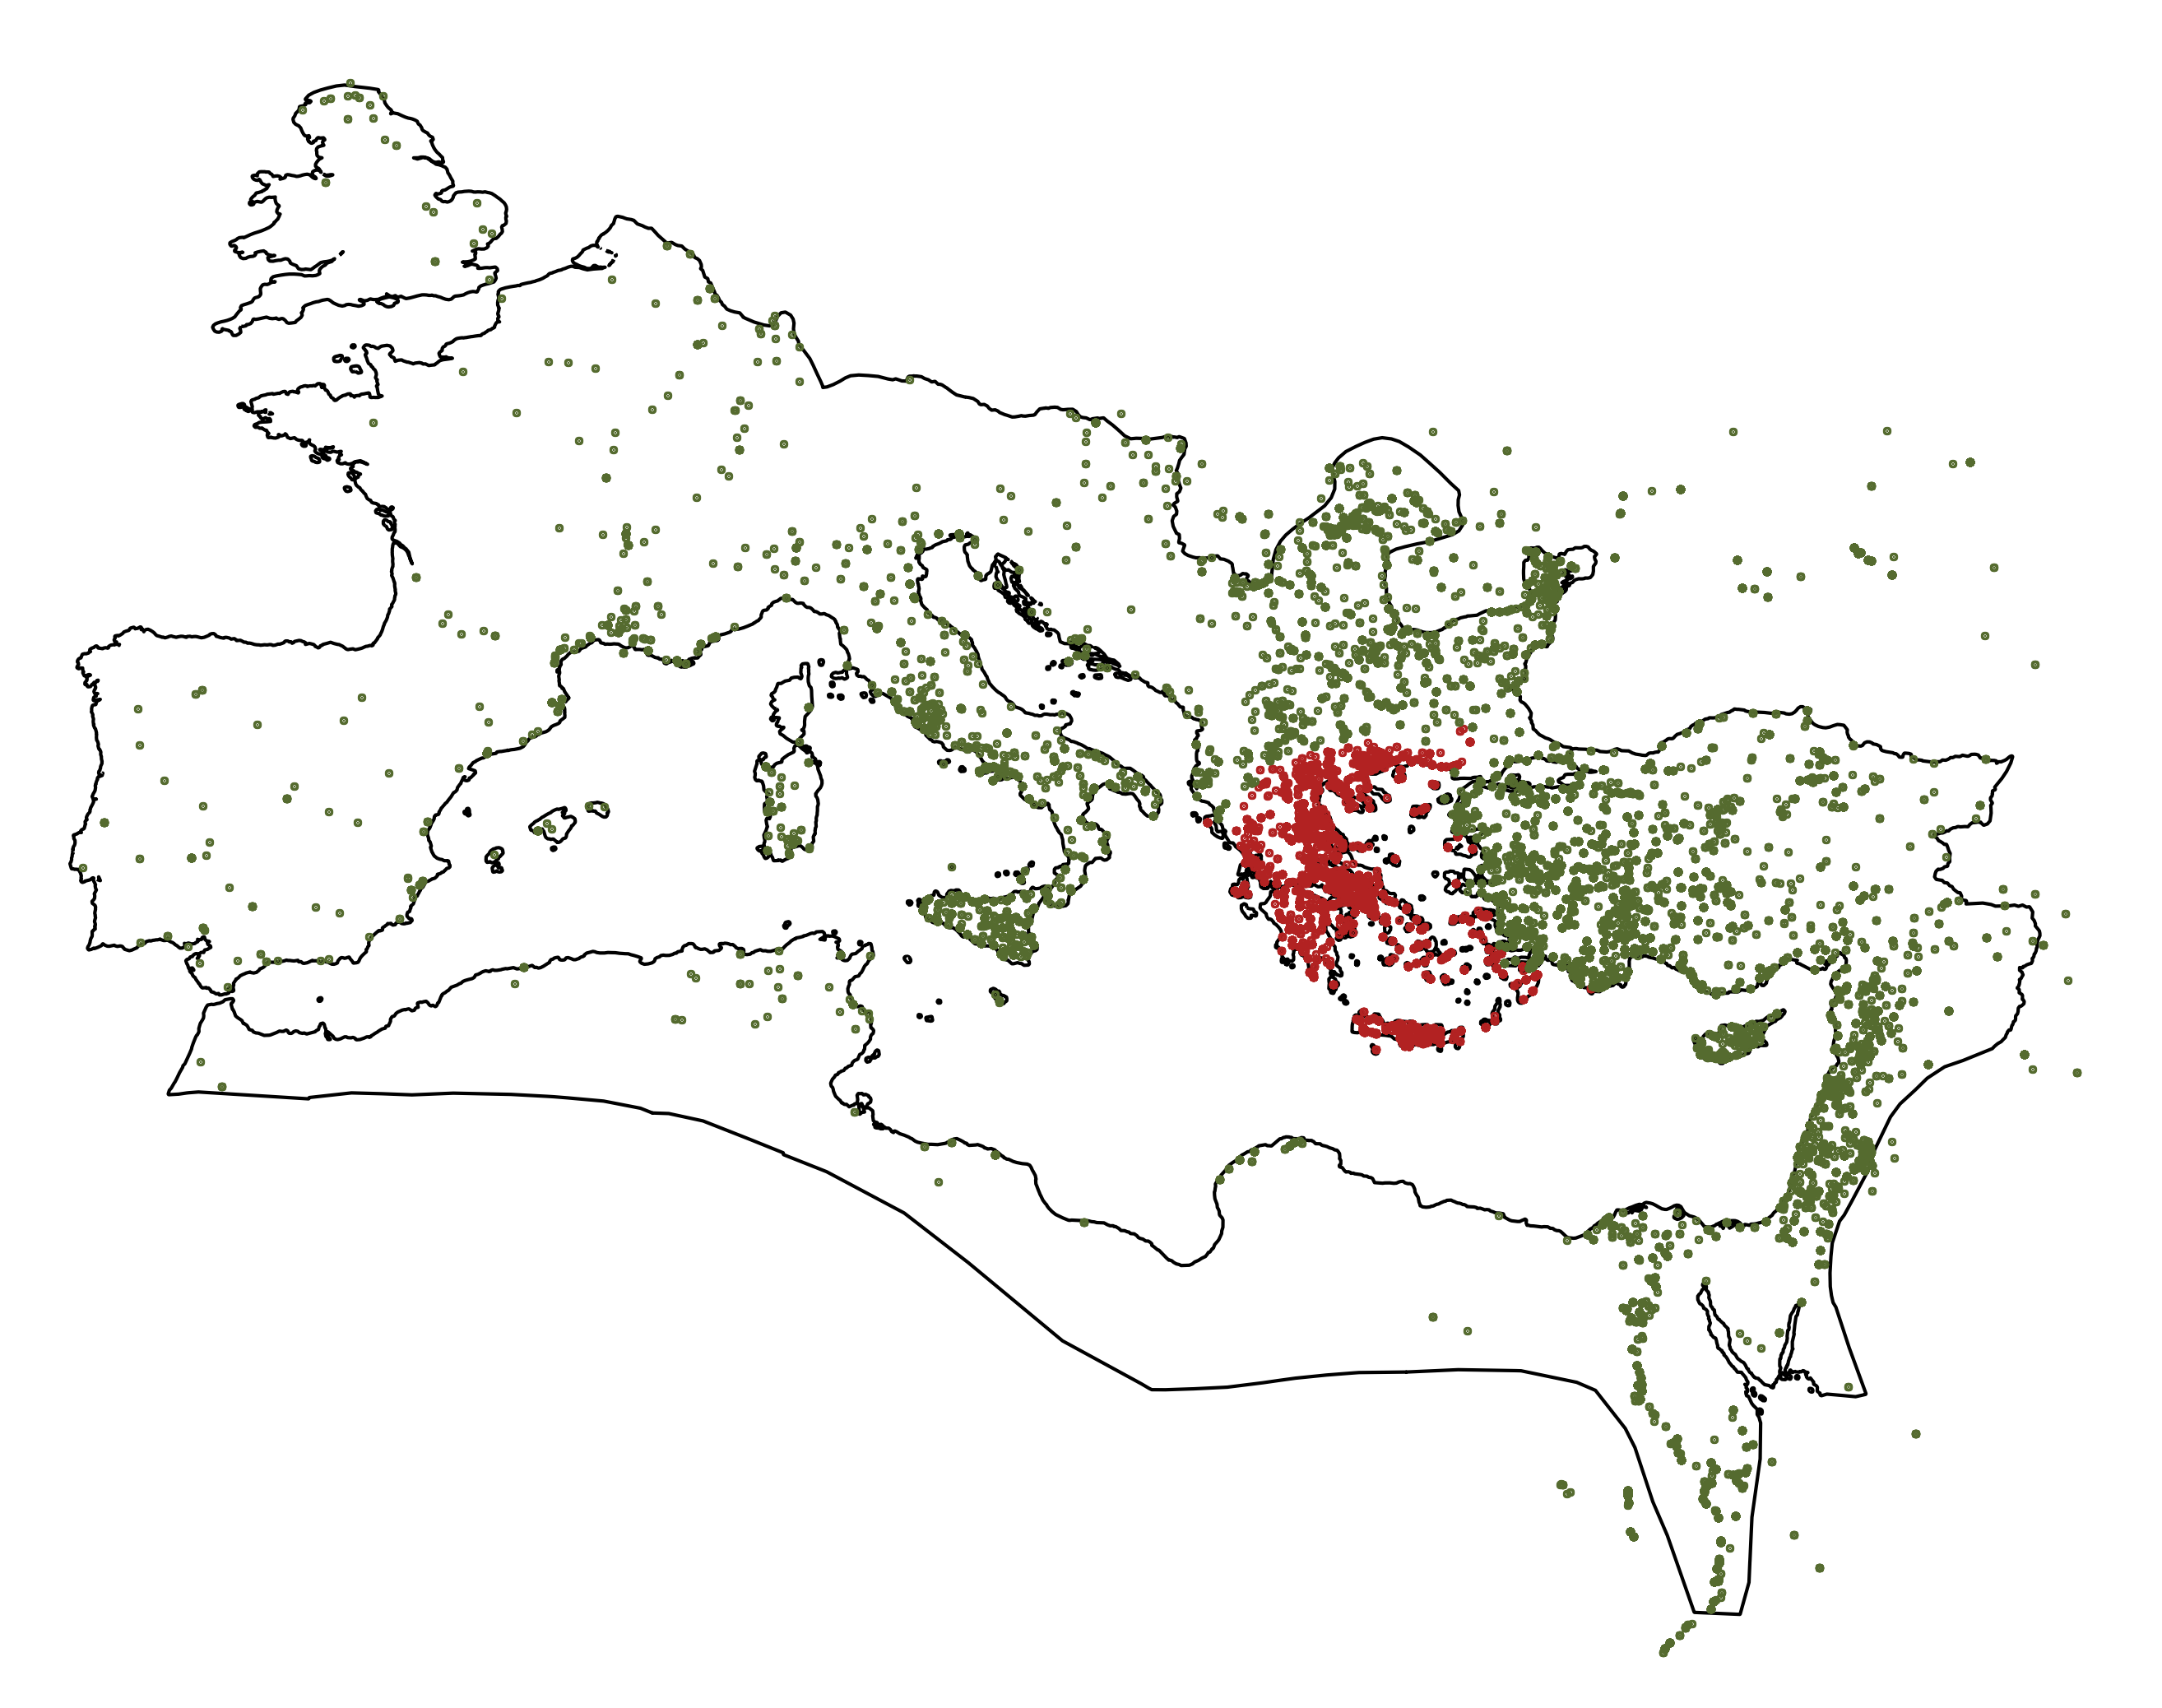

In [22]:
fig, ax = plt.subplots(figsize=(4.45, 3.5), tight_layout=True)
ax.axis("off")
#gplt.kdeplot(GIST[(~GIST["greece?"]) & (GIST["geometry"].notnull())], cmap='Greens', ax=ax, fill=True)
#gplt.kdeplot(GIST[GIST["greece?"]], cmap='Reds', ax=ax, fill=True)

pleiades_regions_merged_buffer_gs.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5)

GIST[GIST["greece?"]].plot(marker=",", markersize=0.02, ax=ax, color="firebrick") #, alpha=0.7)
GIST[~GIST["greece?"]].plot(marker=",", markersize=0.02, ax=ax, color="darkolivegreen") #, alpha=0.7)

ax.set_xlim(-10,43)
ax.set_ylim(22,56)

In [23]:
GIST.head(5)

PHI_ID reference                                           metadata  lines  \
0       1  IG I¬≥\n1  Att. ‚Äî Ath.: Akr. ‚Äî stoich. 35 ‚Äî c. 510-500 a....   12.0   
1       2  IG I¬≥\n2                     Att. ‚Äî non-stoich. ‚Äî c. 500 a.   14.0   
2       3  IG I¬≥\n3                     Att. ‚Äî stoich. 21 ‚Äî 490-480 a.   13.0   
3       4  IG I¬≥\n4                       Att. ‚Äî stoich. 38 ‚Äî 485/4 a.   56.0   
4       5  IG I¬≥\n5                                   Att. ‚Äî c. 500 a.    6.0   

                                            text_raw  \
0  ·ºîŒ¥ŒøœáœÉŒµŒΩ œÑŒøÕÇŒπ Œ¥·Ω≥ŒºŒøŒπŒá œÑÃ£[·Ω∏œÇ ·ºê Œ£]Œ±ŒªŒ±ŒºÃ£[·øñŒΩŒπ Œ∫ŒªŒµœÅ·Ωπœá...   
1  [‚Ä§‚Ä§8-9‚Ä§‚Ä§‚Ä§]ŒΩÃ£ Œ≤ŒøŒª ‚Äî ‚Äî ‚Äî ‚Äî ‚Äî ‚Äî ‚Äî ‚Äî ‚Äî ‚Äî\n[‚Ä§6-7‚Ä§‚Ä§]...   
2  [‚Ä§]Œ±œÅ[‚Ä§‚Ä§‚Ä§‚Ä§]Œπ ‚ÑéŒµœÅŒ±Œ∫ŒªŒµŒπŒø[‚Ä§‚Ä§5‚Ä§‚Ä§]\n[‚Ä§]Œ±œÅÃ£Œø#‚Å∑[‚Ä§] œÑŒπ...   
3  [‚Ä§‚Ä§‚Ä§‚Ä§‚Ä§‚Ä§‚Ä§‚Ä§‚Ä§‚Ä§‚Ä§‚Ä§‚Ä§‚Ä§‚Ä§‚Ä§‚Ä§‚Ä§38‚Ä§‚Ä§‚Ä§‚Ä§‚Ä§‚Ä§‚Ä§‚Ä§‚Ä§‚Ä§‚Ä§‚Ä§‚Ä§‚Ä§‚Ä§‚Ä§‚Ä§‚Ä§]\n[‚Ä§‚Ä§‚Ä§...   
4  [·ºîŒ¥ŒøœáœÉŒµ]ŒΩ [‚ãÆ œÑŒµÕÇŒπ Œ≤ŒøŒªŒµÕÇŒπ] ‚ãÆ Œ∫Œ±·Ω∂ [œÑ]ŒøÕÇŒπ Œ¥·Ω≥ŒºŒøŒπ ‚ãÆ...   

                                           text_iphi  \
0  ŒµŒ¥ŒøœáœÉŒµŒΩ œÑŒøŒπ Œ¥ŒµŒºŒøŒπ œÑ[ŒøœÇ Œµ œÉ]Œ±ŒªŒ±Œº[ŒπŒΩŒπ Œ∫ŒªŒµœÅŒøœá]ŒøœÇ ...   
1  [--------]ŒΩ Œ≤ŒøŒª ---------- [------] Œ± ŒµŒ∫ŒøŒΩ ---...   
2  [-]Œ±œÅ[----]Œπ ŒµœÅŒ±Œ∫ŒªŒµŒπŒø[-----] [-]Œ±œÅŒø [-] œÑŒπŒ∏ŒµŒΩŒ±...   
3  [--------------------------------------] [----...   
4  [ŒµŒ¥ŒøœáœÉŒµ]ŒΩ [ œÑŒµŒπ Œ≤ŒøŒªŒµŒπ] Œ∫Œ±Œπ [œÑ]ŒøŒπ Œ¥ŒµŒºŒøŒπ ŒøœÑŒµ œÄŒ±œÅ...   

                             clean_text_conservative  \
0  ·ºîŒ¥ŒøœáœÉŒµŒΩ œÑŒøÕÇŒπ Œ¥·Ω≥ŒºŒøŒπ œÑŒ±ŒªŒ±ŒºŒøœÇ Œø·º∞Œ∫ŒµÕÇŒΩ ·ºê·æ∂ Œ£Œ±ŒªŒ±Œº·øñŒΩŒπ ...   
1  ŒΩ Œ≤ŒøŒª Œ± ‚ÑéŒµŒ∫ŒøŒΩ œÉŒπŒøŒΩ Œ≥ŒΩŒøœÉŒ∏ŒµÕÇŒπ Œ¥·Ω≤ ŒΩ ·ºÄœÑŒµœáŒΩŒøœÇ Œº·Ω≤ œÄ ...   
2  Œ±œÅŒπ ‚ÑéŒµœÅŒ±Œ∫ŒªŒµŒπŒø Œ±œÅŒø œÑŒπŒ∏·Ω≥ŒΩŒ±Œπ œÑ·Ω∏œÇ ·ºÄ·Ω≥œÑŒ±œÇ œÑœÅŒπ·Ω±Œ∫ŒøŒΩœÑŒ± ...   
3  Œ¥·Ω≥ œÑŒπœÇ Œ±ŒΩ ·ºí œÜœÅŒøœÅ·Ω∞ŒΩ Œº ŒΩœÑ·Ω≥Œ∫ŒøŒΩœÑŒ± Œ¥œáŒº·Ω∞œÇ œÑ Œ±œÇ ‚ÑéŒµœÇ œÄ...   
4  ŒΩ Œ∫Œ±·Ω∂ ŒøÕÇŒπ Œ¥·Ω≥ŒºŒøŒπ ‚Ñé·ΩπœÑŒµ Œ†Œ±œÅŒ±ŒπŒ≤·Ω±œÑŒµœÇ ŒªŒµŒπŒ± Œ∏ŒΩ œÑ·Ω∏œÇ ‚ÑéŒπ...   

                        clean_text_interpretive_word  \
0  ·ºîŒ¥ŒøœáœÉŒµŒΩ œÑŒøÕÇŒπ Œ¥·Ω≥ŒºŒøŒπ œÑ·Ω∏œÇ ·ºê Œ£Œ±ŒªŒ±Œº·øñŒΩŒπ Œ∫ŒªŒµœÅ·ΩπœáŒøœÇ Œø·º∞Œ∫...   
1  ŒΩ Œ≤ŒøŒª Œ± ‚ÑéŒµŒ∫ŒøŒΩ œÉŒπŒøŒΩ Œ≥ŒΩŒøœÉŒ∏ŒµÕÇŒπ Œ¥·Ω≤ ŒΩ ·ºÄœÑŒµœáŒΩŒøœÇ Œº·Ω≤ œÄ ...   
2  Œ±œÅŒπ ‚ÑéŒµœÅŒ±Œ∫ŒªŒµŒπŒø Œ±œÅŒø œÑŒπŒ∏·Ω≥ŒΩŒ±Œπ œÑ·Ω∏œÇ ·ºÄŒ∏ŒªŒøŒ∏·Ω≥œÑŒ±œÇ œÑœÅŒπ·Ω±Œ∫Œø...   
3  ·ºê·Ω∞ŒΩ Œ¥·Ω≥ œÑŒπœÇ Œ±ŒΩ ·ºí œÜœÅŒøœÅ·Ω∞ŒΩ Œº·Ω≤ œÄŒµŒΩœÑ·Ω≥Œ∫ŒøŒΩœÑŒ± Œ¥œÅŒ±œáŒº·Ω∞œÇ œÑ...   
4  ·ºîŒ¥ŒøœáœÉŒµŒΩ œÑŒµÕÇŒπ Œ≤ŒøŒªŒµÕÇŒπ Œ∫Œ±·Ω∂ œÑŒøÕÇŒπ Œ¥·Ω≥ŒºŒøŒπ ‚Ñé·ΩπœÑŒµ Œ†Œ±œÅŒ±ŒπŒ≤...   

                                             lemmata        raw_date  \
0  {'data': ['·ºîŒ¥ŒøœáœÉŒµŒΩ', 'œÑŒøÕÇŒπ', 'Œ¥Œ≠ŒºŒøŒπ', 'œÑ·Ω∏œÇ', '...  c. 510-500 a.    
1  {'data': ['ŒΩ', 'Œ≤Œø·ø¶œÇ', 'Œ±', 'Œ∏œçŒøœÇ', 'Œ≥ŒΩœéœÉœÑŒ∑œÇ',...       c. 500 a.   
2  {'data': ['·º¨œÅ', 'Œµ·º∞œÉœÄŒªŒ≠œâ', '·ºàŒ∏·øÜŒΩŒ±Œπ', 'œÑ·Ω∂œÇ', '·ºÄ...      490-480 a.   
3  {'data': ['·ºêŒ¨ŒΩ', 'œÑŒπœÇ', '·ºêŒΩ', '·ºí', 'œÜœÅŒøœÖœÅŒ¨', '...        485/4 a.   
4  {'data': ['Œ¥ŒøŒ∫Œ≠œâ', 'Œ≤ŒøœÖŒªŒÆ', 'Œ∫Œ±·Ω∂', '·ΩÅ', 'Œ¥·øÜŒºŒøœÇ...       c. 500 a.   

   not_before  not_after                           date_type  region_main_id  \
0      -511.0     -499.0  {'data': ['range', 'phase', 'ca']}          1701.0   
1      -505.0     -495.0  {'data': ['exact', 'phase', 'ca']}          1701.0   
2      -490.0     -480.0                 {'data': ['range']}          1701.0   
3      -485.0     -484.0                 {'data': ['range']}          1701.0   
4      -505.0     -495.0  {'data': ['exact', 'phase', 'ca']}          1701.0   

   region_sub_id                 TM_ID        EDH_ID       EDCS_ID  \
0         1700.0  {'data': ['786251']}  {'data': []}  {'data': []}   
1         1700.0  {'data': ['786252']}  {'data': []}  {'data': []}   
2         1700.0  {'data': ['786253']}  {'data': []}  {'data': []}   
3         1700.0  {'data': ['786254']}  {'data': []}  {'data': []}   
4 

In [41]:
len(GIST[GIST["random_dates"].apply(lambda x: x[0]<-146)])

43023

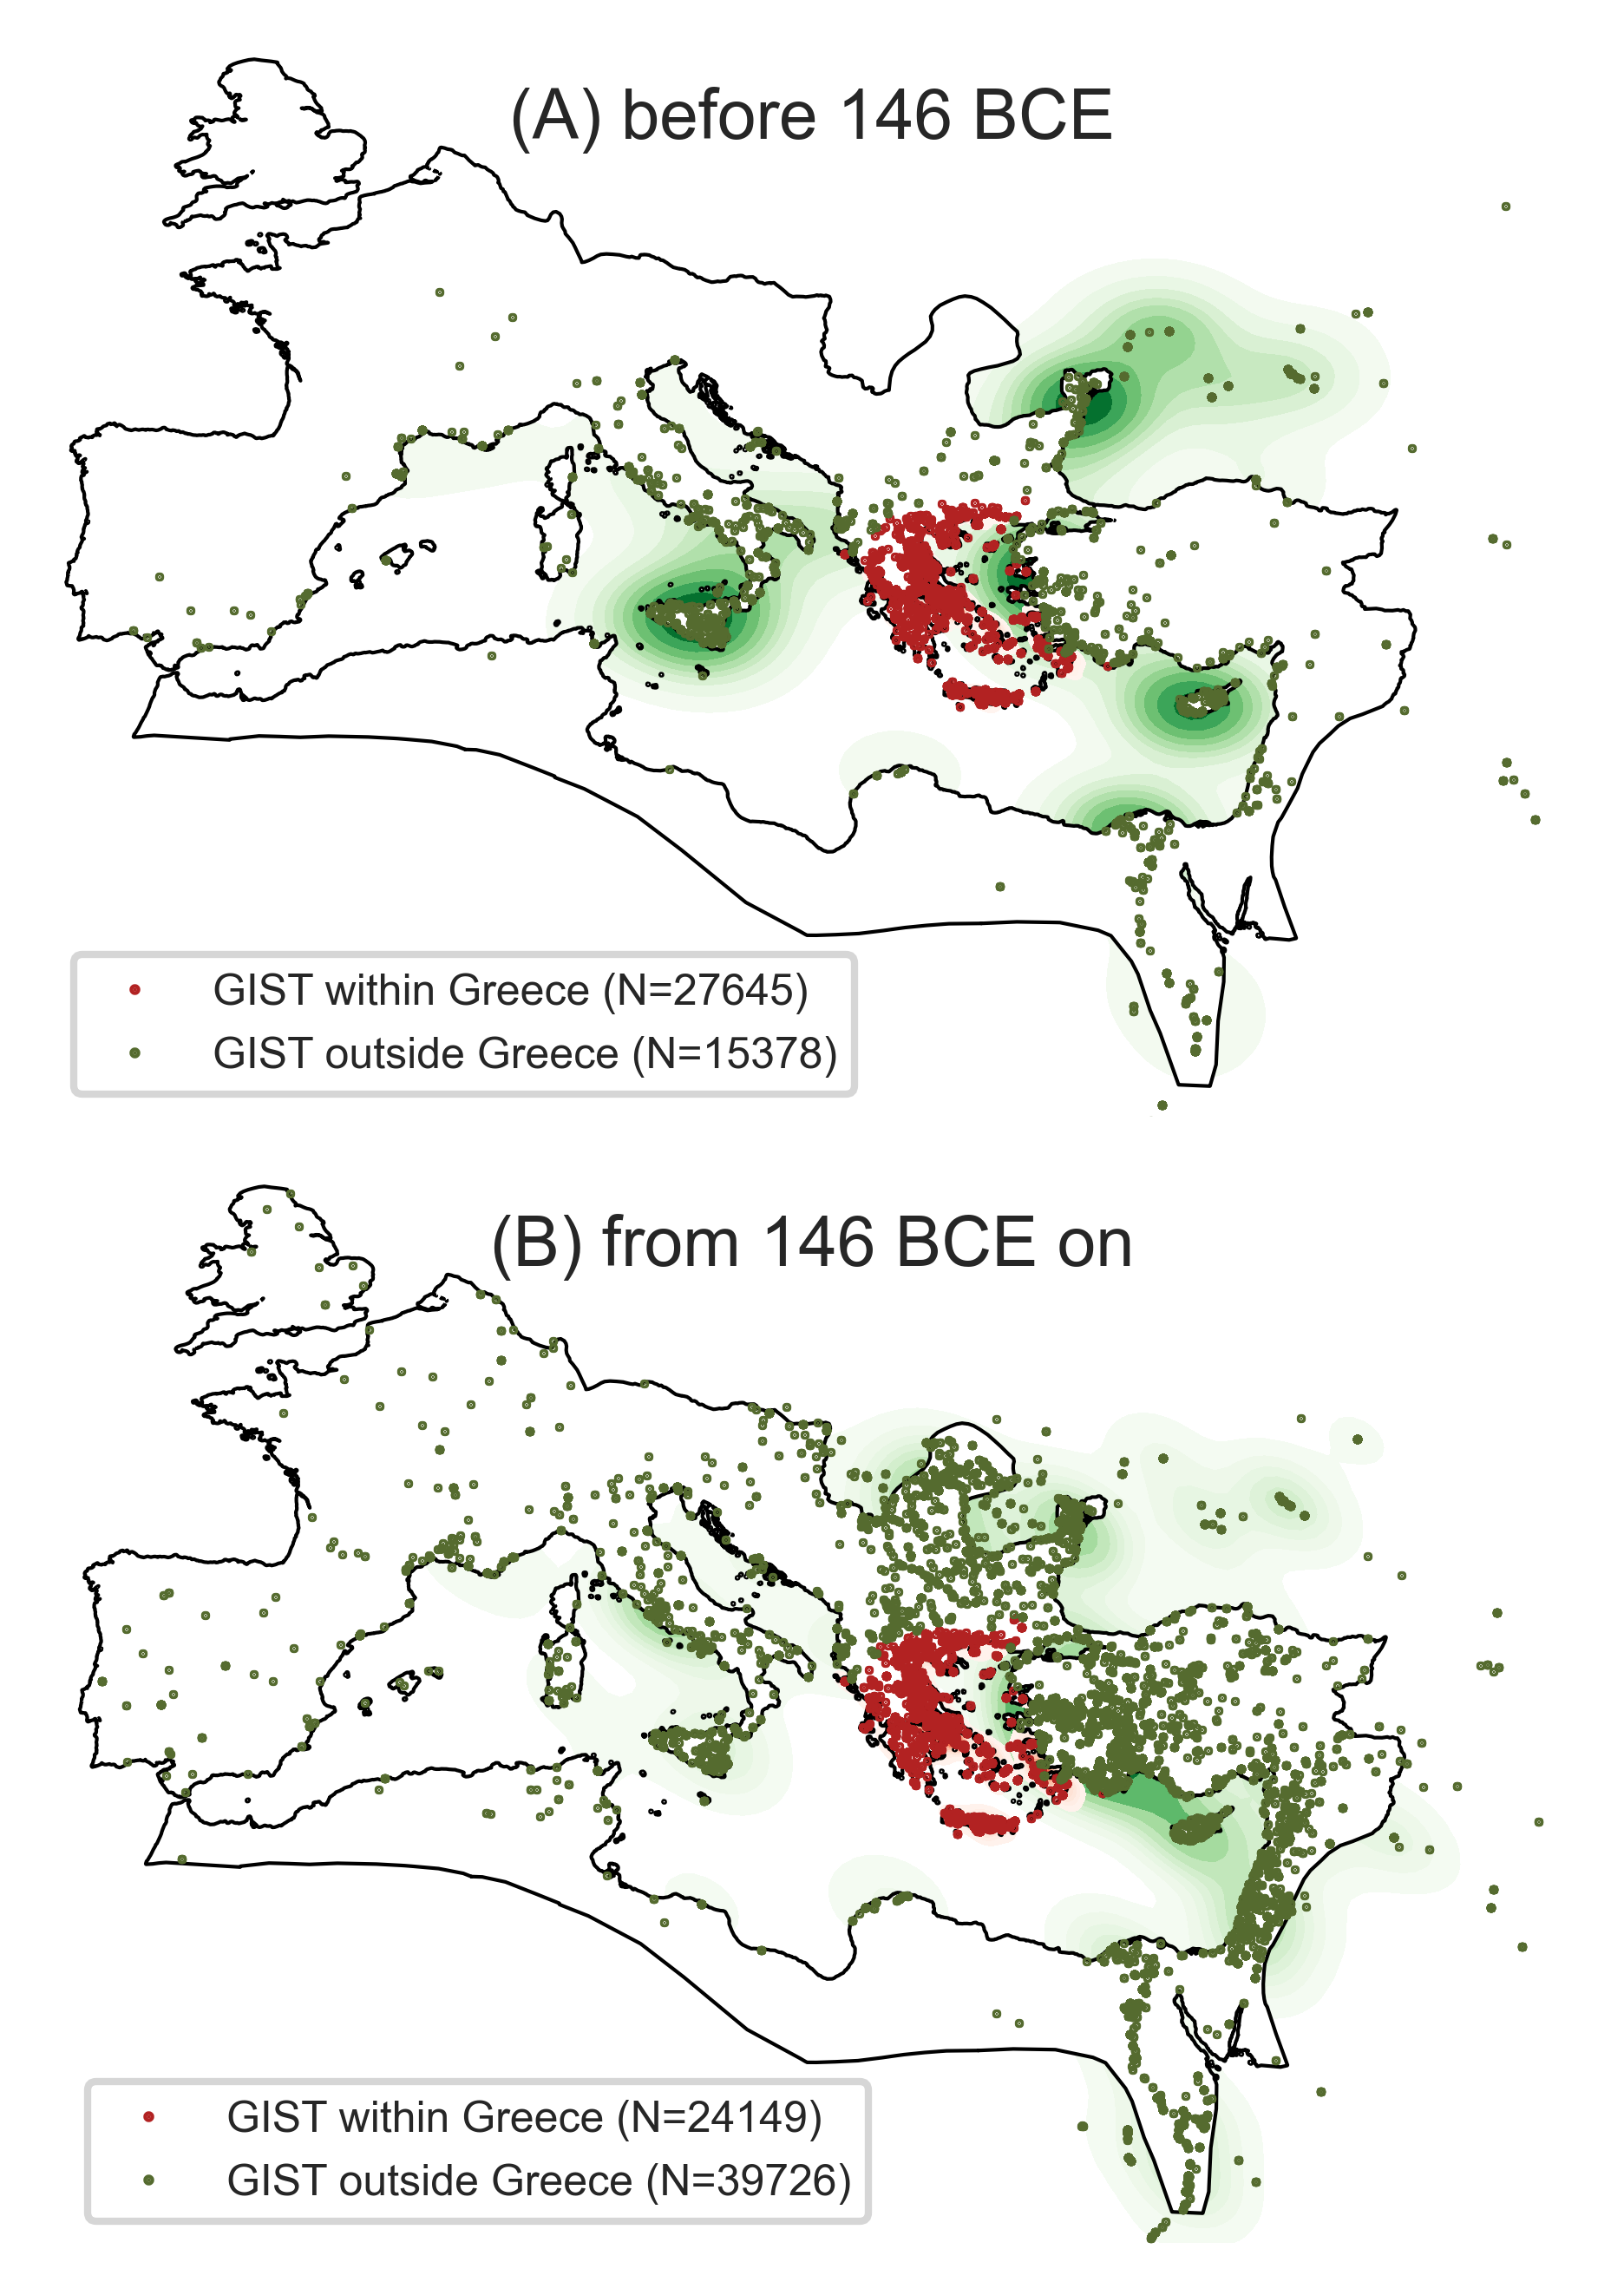

In [30]:
fig, [ax1, ax2] = plt.subplots(2,1, figsize=(4.45, 4.45), tight_layout=True)

titles=["(A) before 146 BCE", "(B) from 146 BCE on"]

for date_mask, ax, title in zip([GIST["random_dates"].apply(lambda x: x[0]<-146),
                                 GIST["random_dates"].apply(lambda x: x[0]>=-146)], [ax1, ax2],
                                titles):

    gplt.kdeplot(GIST[(date_mask) & (~GIST["greece?"])], cmap='Greens', ax=ax, fill=True)
    gplt.kdeplot(GIST[(date_mask) & (GIST["greece?"])], cmap='Reds', ax=ax, fill=True)
    pleiades_regions_merged_buffer_gs.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5)
    GIST[(date_mask) & (GIST["greece?"])].plot(marker=",", markersize=0.02, ax=ax, color="firebrick") #, alpha=0.7)
    GIST[(date_mask) & (~GIST["greece?"])].plot(marker=",", markersize=0.02, ax=ax, color="darkolivegreen") #, alpha=0.7)
    ax.set_title(title, pad=-12)

    ax.axis("off")
    ax.set_xlim(-10,47)
    ax.set_ylim(22,55.5)

    legend_labels = [
        "GIST within Greece (N={})".format(str(sum((date_mask) & (GIST["greece?"])))),
        "GIST outside Greece (N={})".format(str(sum((date_mask) & (~GIST["greece?"]))))]
    colors=["firebrick", "darkolivegreen"] #, "darkgrey"]
    markers = [plt.Line2D([], [], markersize=0.5, color=color, marker="o", linewidth=0)  for color in colors]
    #markers = [mpatches.Circle((0.05, 0.05), radius=0.02, facecolor=color, edgecolor=None) for color in colors]
    ax.legend(markers, legend_labels, numpoints=1, fontsize=6, bbox_to_anchor=(0.0, 0), loc='lower left')

In [191]:
save_figure(fig, "map_GIST_146BCE")

In [31]:
polis = polis[(polis["geometry"].notnull()) & (~polis["geometry"].is_empty)]

/Users/kasev/Projects/EpiMR/epimr_venv/lib/python3.9/site-packages/geopandas/geoseries.py:749: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


In [42]:
geod = Geod(ellps="WGS84")
def get_dist_m(inscr_geo, city_geo):
    line_string = LineString([inscr_geo, city_geo])
    return np.round(geod.geometry_length(line_string), 2)

def ckdnearest(inscriptions, polis):

    polis = polis[['name', 'geometry']]
    insr_geometries = np.array(list(inscriptions.geometry.apply(lambda x: (x.x, x.y))))
    polis_geometries = np.array(list(polis.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(polis_geometries)
    dist, idx = btree.query(insr_geometries, k=1)
    nearest_polis_df = polis.iloc[idx].rename(columns={"geometry": "polis_geo"}).reset_index(drop=True)
    nearest_polis_df["polis_geo"] = [[geom.x, geom.y] for geom in nearest_polis_df["polis_geo"]]

    merge_gdf = pd.concat(
        [
            inscriptions.reset_index(drop=True),
            nearest_polis_df,
            pd.Series(dist, name="polis_dist")
        ],
        axis=1)
    merge_gdf["polis_dist"] = merge_gdf.apply(lambda row: get_dist_m(row.geometry, row["polis_geo"]), axis=1)
    return merge_gdf

In [34]:
%%time
GIST = ckdnearest(GIST, polis)

CPU times: user 6.27 s, sys: 371 ms, total: 6.64 s
Wall time: 6.95 s


In [35]:
GIST[:230]

PHI_ID          reference  \
0         1           IG I¬≥\n1   
1         4           IG I¬≥\n4   
2         5           IG I¬≥\n5   
3         6           IG I¬≥\n6   
4        11          IG I¬≥\n11   
5        14          IG I¬≥\n14   
6        15          IG I¬≥\n15   
7        16          IG I¬≥\n16   
8        17          IG I¬≥\n17   
9        22          IG I¬≥\n22   
10       29          IG I¬≥\n29   
11       31          IG I¬≥\n31   
12       32          IG I¬≥\n32   
13       33          IG I¬≥\n33   
14       44          IG I¬≥\n44   
15       46          IG I¬≥\n46   
16       51          IG I¬≥\n50   
17       59          IG I¬≥\n58   
18       63          IG I¬≥\n62   
19       65          IG I¬≥\n64   
20       71          IG I¬≥\n70   
21       77          IG I¬≥\n76   
22       81          IG I¬≥\n79   
23       88          IG I¬≥\n86   
24       93          IG I¬≥\n91   
25       97          IG I¬≥\n95   
26      103         IG I¬≥\n101   
27      124         IG I¬≥\n121   
28      125         IG I¬≥\n122   
29      128         IG I¬≥\n125   
30      132         IG I¬≥\n129   
31      138         IG I¬≥\n135   
32      142         IG I¬≥\n139   
33      148         IG I¬≥\n145   
34      158         IG I¬≥\n155   
35      160     IG I¬≥\n157/213   
36      168         IG I¬≥\n165   
37      169    IG I¬≥\n165,p952   
38      173         IG I¬≥\n169   
39      174    IG I¬≥\n169,p952   
40      187         IG I¬≥\n182   
41      193         IG I¬≥\n187   
42      195      IG I¬≥\n188bis   
43      202         IG I¬≥\n196   
44      208         IG I¬≥\n202   
45      216         IG I¬≥\n210   
46      232         IG I¬≥\n225   
47      234         IG I¬≥\n227   
48      235      IG I¬≥\n227bis   
49      239         IG I¬≥\n231   
50      242         IG I¬≥\n234   
51      245         IG I¬≥\n237   
52      246     IG I¬≥\n237 bis   
53      247         IG I¬≥\n238   
54      248         IG I¬≥\n239   
55      249         IG I¬≥\n240   
56      250         IG I¬≥\n241   
57      252         IG I¬≥\n243   
58      257      IG I¬≥\n247bis   
59      258         IG I¬≥\n248   
60      261         IG I¬≥\n251   
61      263         IG I¬≥\n253   
62      264         IG I¬≥\n254   
63      269      IG I¬≥\n258bis   
64      374         IG I¬≥\n363   
65      379      IG I¬≥\n367bis   
66      382         IG I¬≥\n370   
67      396         IG I¬≥\n384   
68      397         IG I¬≥\n385   
69      398         IG I¬≥\n386   
70      399         IG I¬≥\n387   
71      400         IG I¬≥\n388   
72      401         IG I¬≥\n389   
73      402         IG I¬≥\n390   
74      403         IG I¬≥\n391   
75      404         IG I¬≥\n392   
76      405         IG I¬≥\n393   
77      406         IG I¬≥\n394   
78      407         IG I¬≥\n395   
79      408         IG I¬≥\n396   
80      409         IG I¬≥\n397   
81      410         IG I¬≥\n398   
82      411         IG I¬≥\n399   
83      412         IG I¬≥\n400   
84      413         IG I¬≥\n401   
85      414         IG I¬≥\n402   
86      415  IG I¬≥\n403/404(i)   
87      417         IG I¬≥\n403   
88      418         IG I¬≥\n404   
89      432         IG I¬≥\n418   
90      435         IG I¬≥\n421   
91      468         IG I¬≥\n454   
92      494      IG I¬≥\n479bis   
93      516         IG I¬≥\n501   
94      517         IG I¬≥\n502   
95      518     IG I¬≥\n503/504   
96      519         IG I¬≥\n505   
97      520         IG I¬≥\n506   
98      521         IG I¬≥\n507   
99      522         IG I¬≥\n508   
100     523         IG I¬≥\n509   
101     524      IG I¬≥\n509bis   
102     525         IG I¬≥\n510   
103     526         IG I¬≥\n511   
104     527         IG I¬≥\n512   
105     528         IG I¬≥\n513   
106     529         IG I¬≥\n514   
107     530         IG I¬≥\n515   
108     531         IG I¬≥\n516   
109     532         IG I¬≥\n517   
110     533         IG I¬≥\n518   
111     534         IG I¬≥\n519   
112     535       IG I¬≥\n520,a   
113     536     

In [36]:
GIST["polis?"] = GIST["polis_dist"] < 5000

In [37]:
def get_duration(start, stop):
    try:
        duration = abs(int(start) - int(stop)) + 1
        if 0 in range(int(start),  int(stop)):
            duration = duration - 1
    except:
        duration = np.nan
    return duration

GIST["duration"] = GIST.apply(lambda row: get_duration(row["not_before"], row["not_after"]), axis=1)

(-5.0, 305.0)

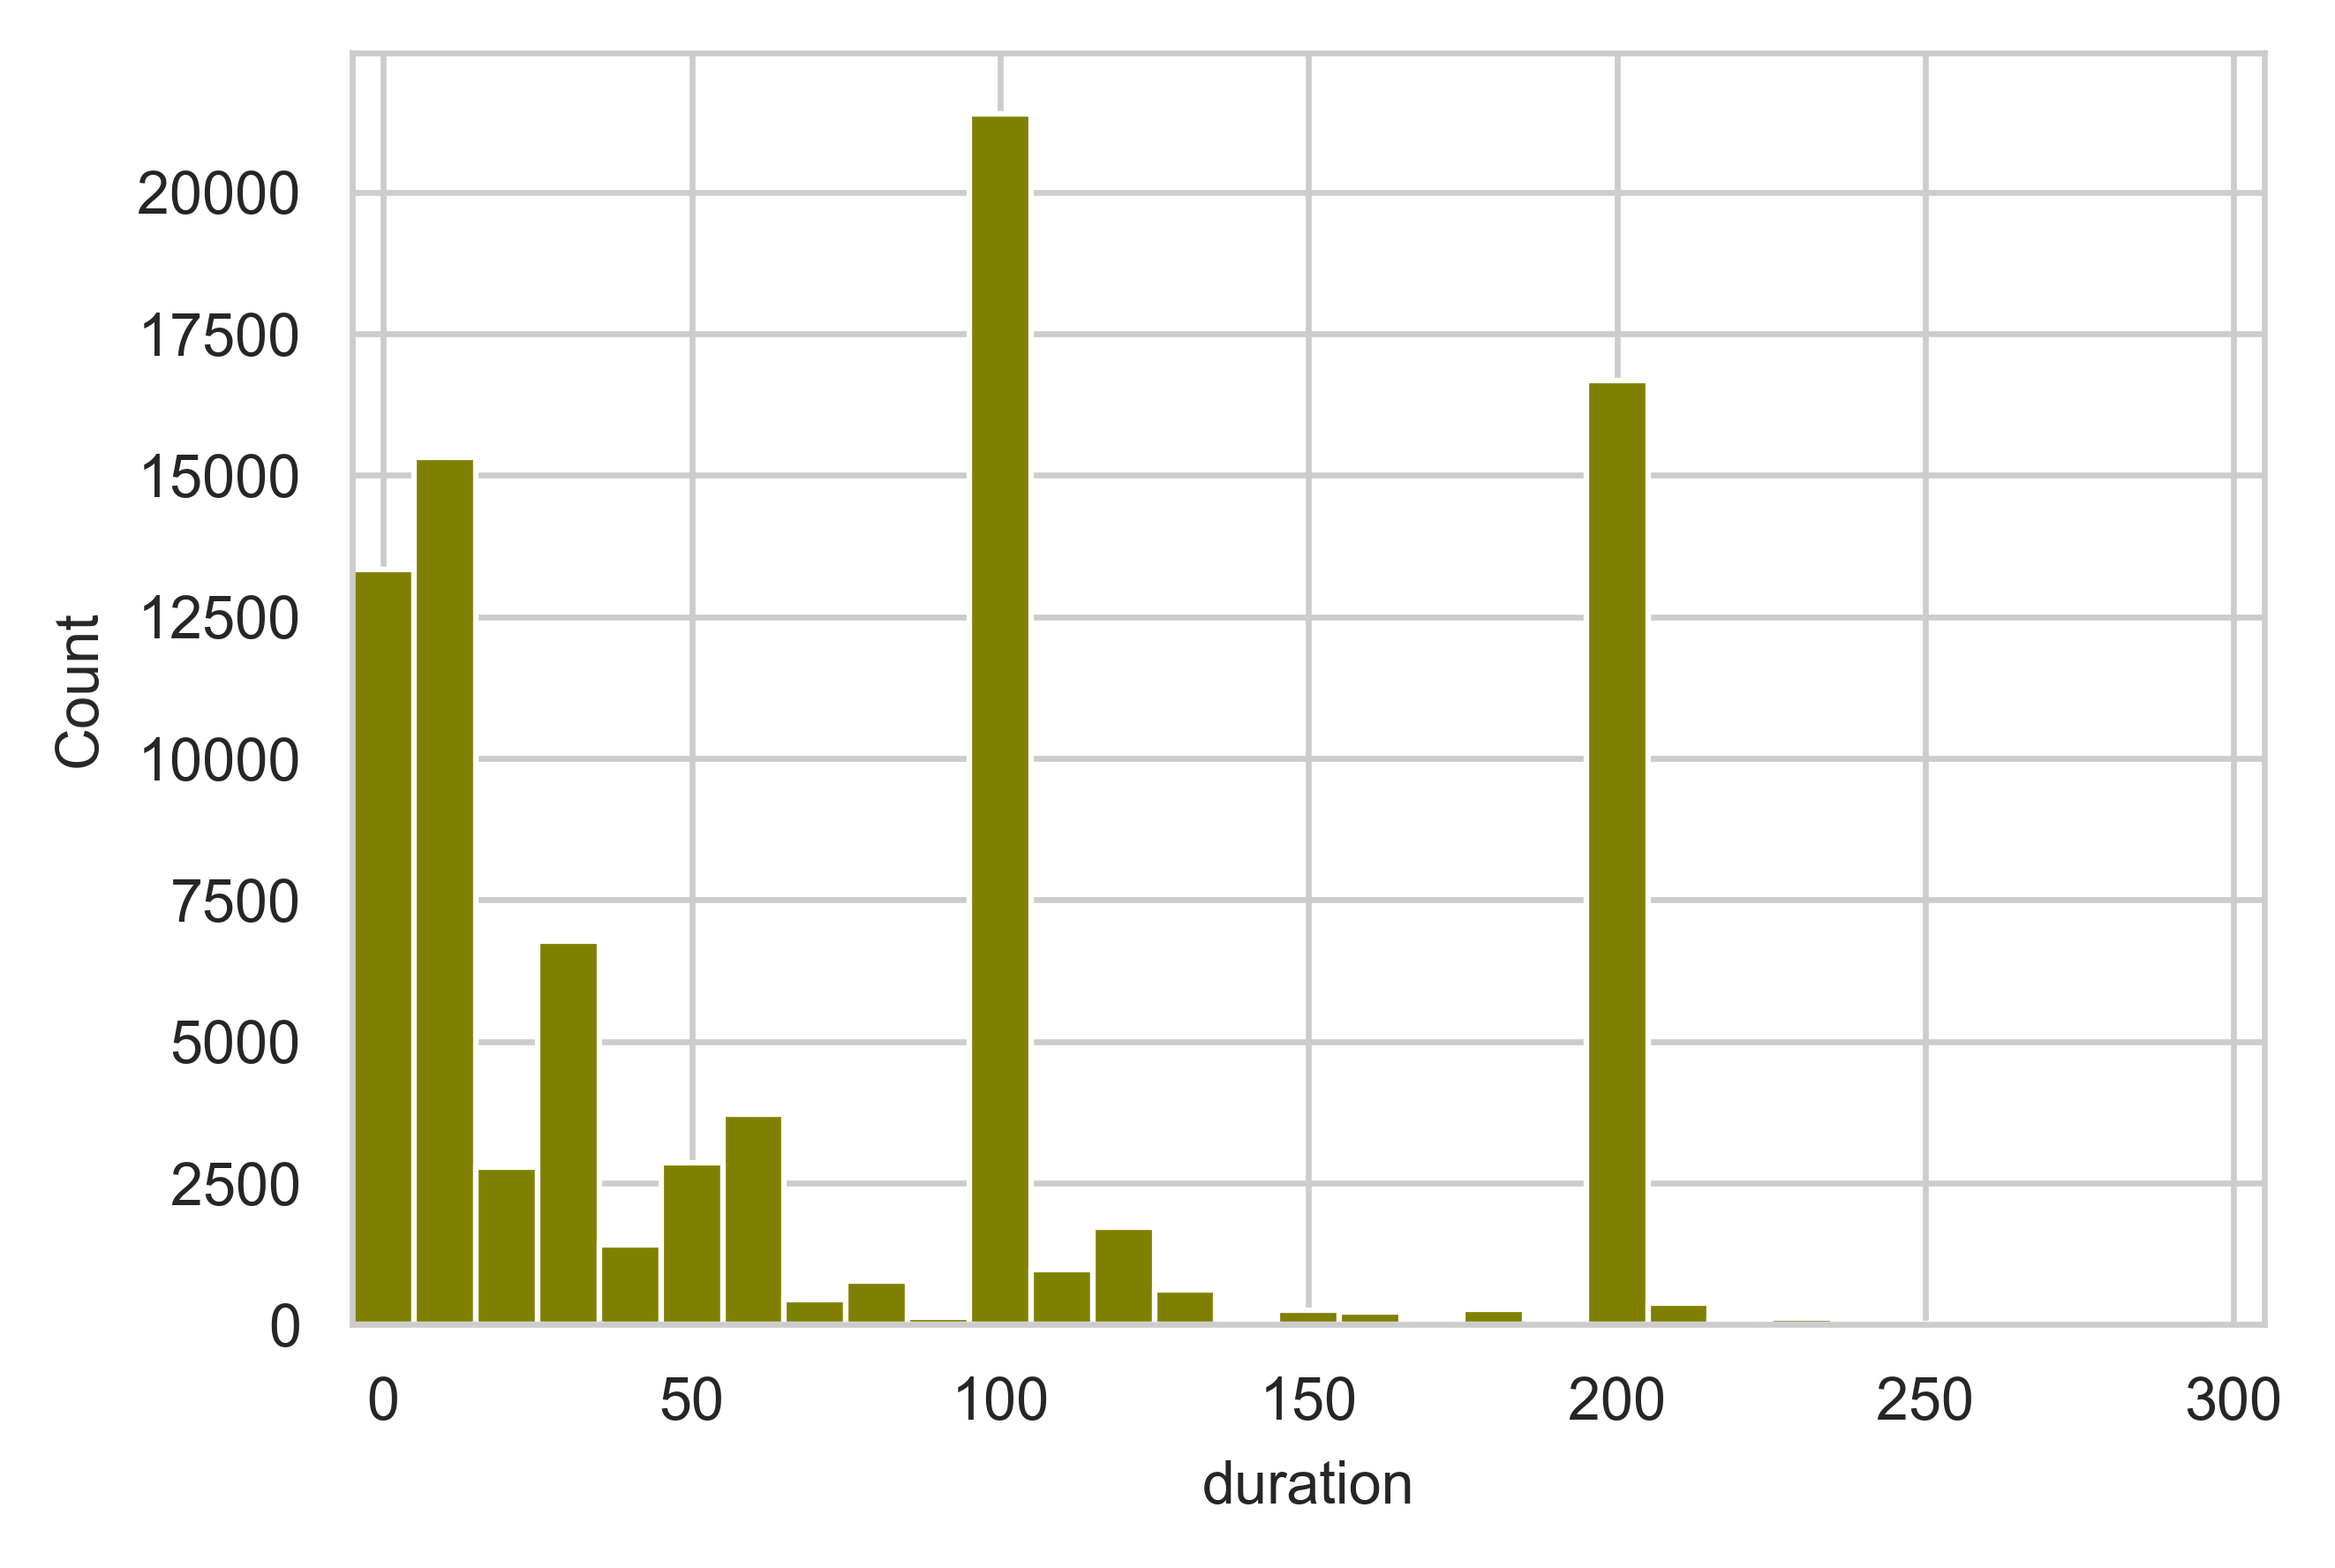

In [38]:
fig, ax = plt.subplots(tight_layout=True)
sns.histplot(GIST["duration"], kde=False, bins=range(-5, 305,10), alpha=1, color="olive", ax=ax)
ax.set_xlim(-5, 305)

In [39]:
save_figure(fig, "GIST_duration")

In [206]:
LIST = gpd.read_parquet("../../LIRE_ETL/data/large_data/LIST_v0.1.parquet")

In [207]:
LIST["random_dates"] = LIST.apply(lambda row: tempun.model_date(row["not_before"], row["not_after"], size=100), axis=1)

In [208]:
len(LIST)

157800

In [209]:
sum((LIST["not_before"].notnull()) | (LIST["not_after"].notnull()))

157800

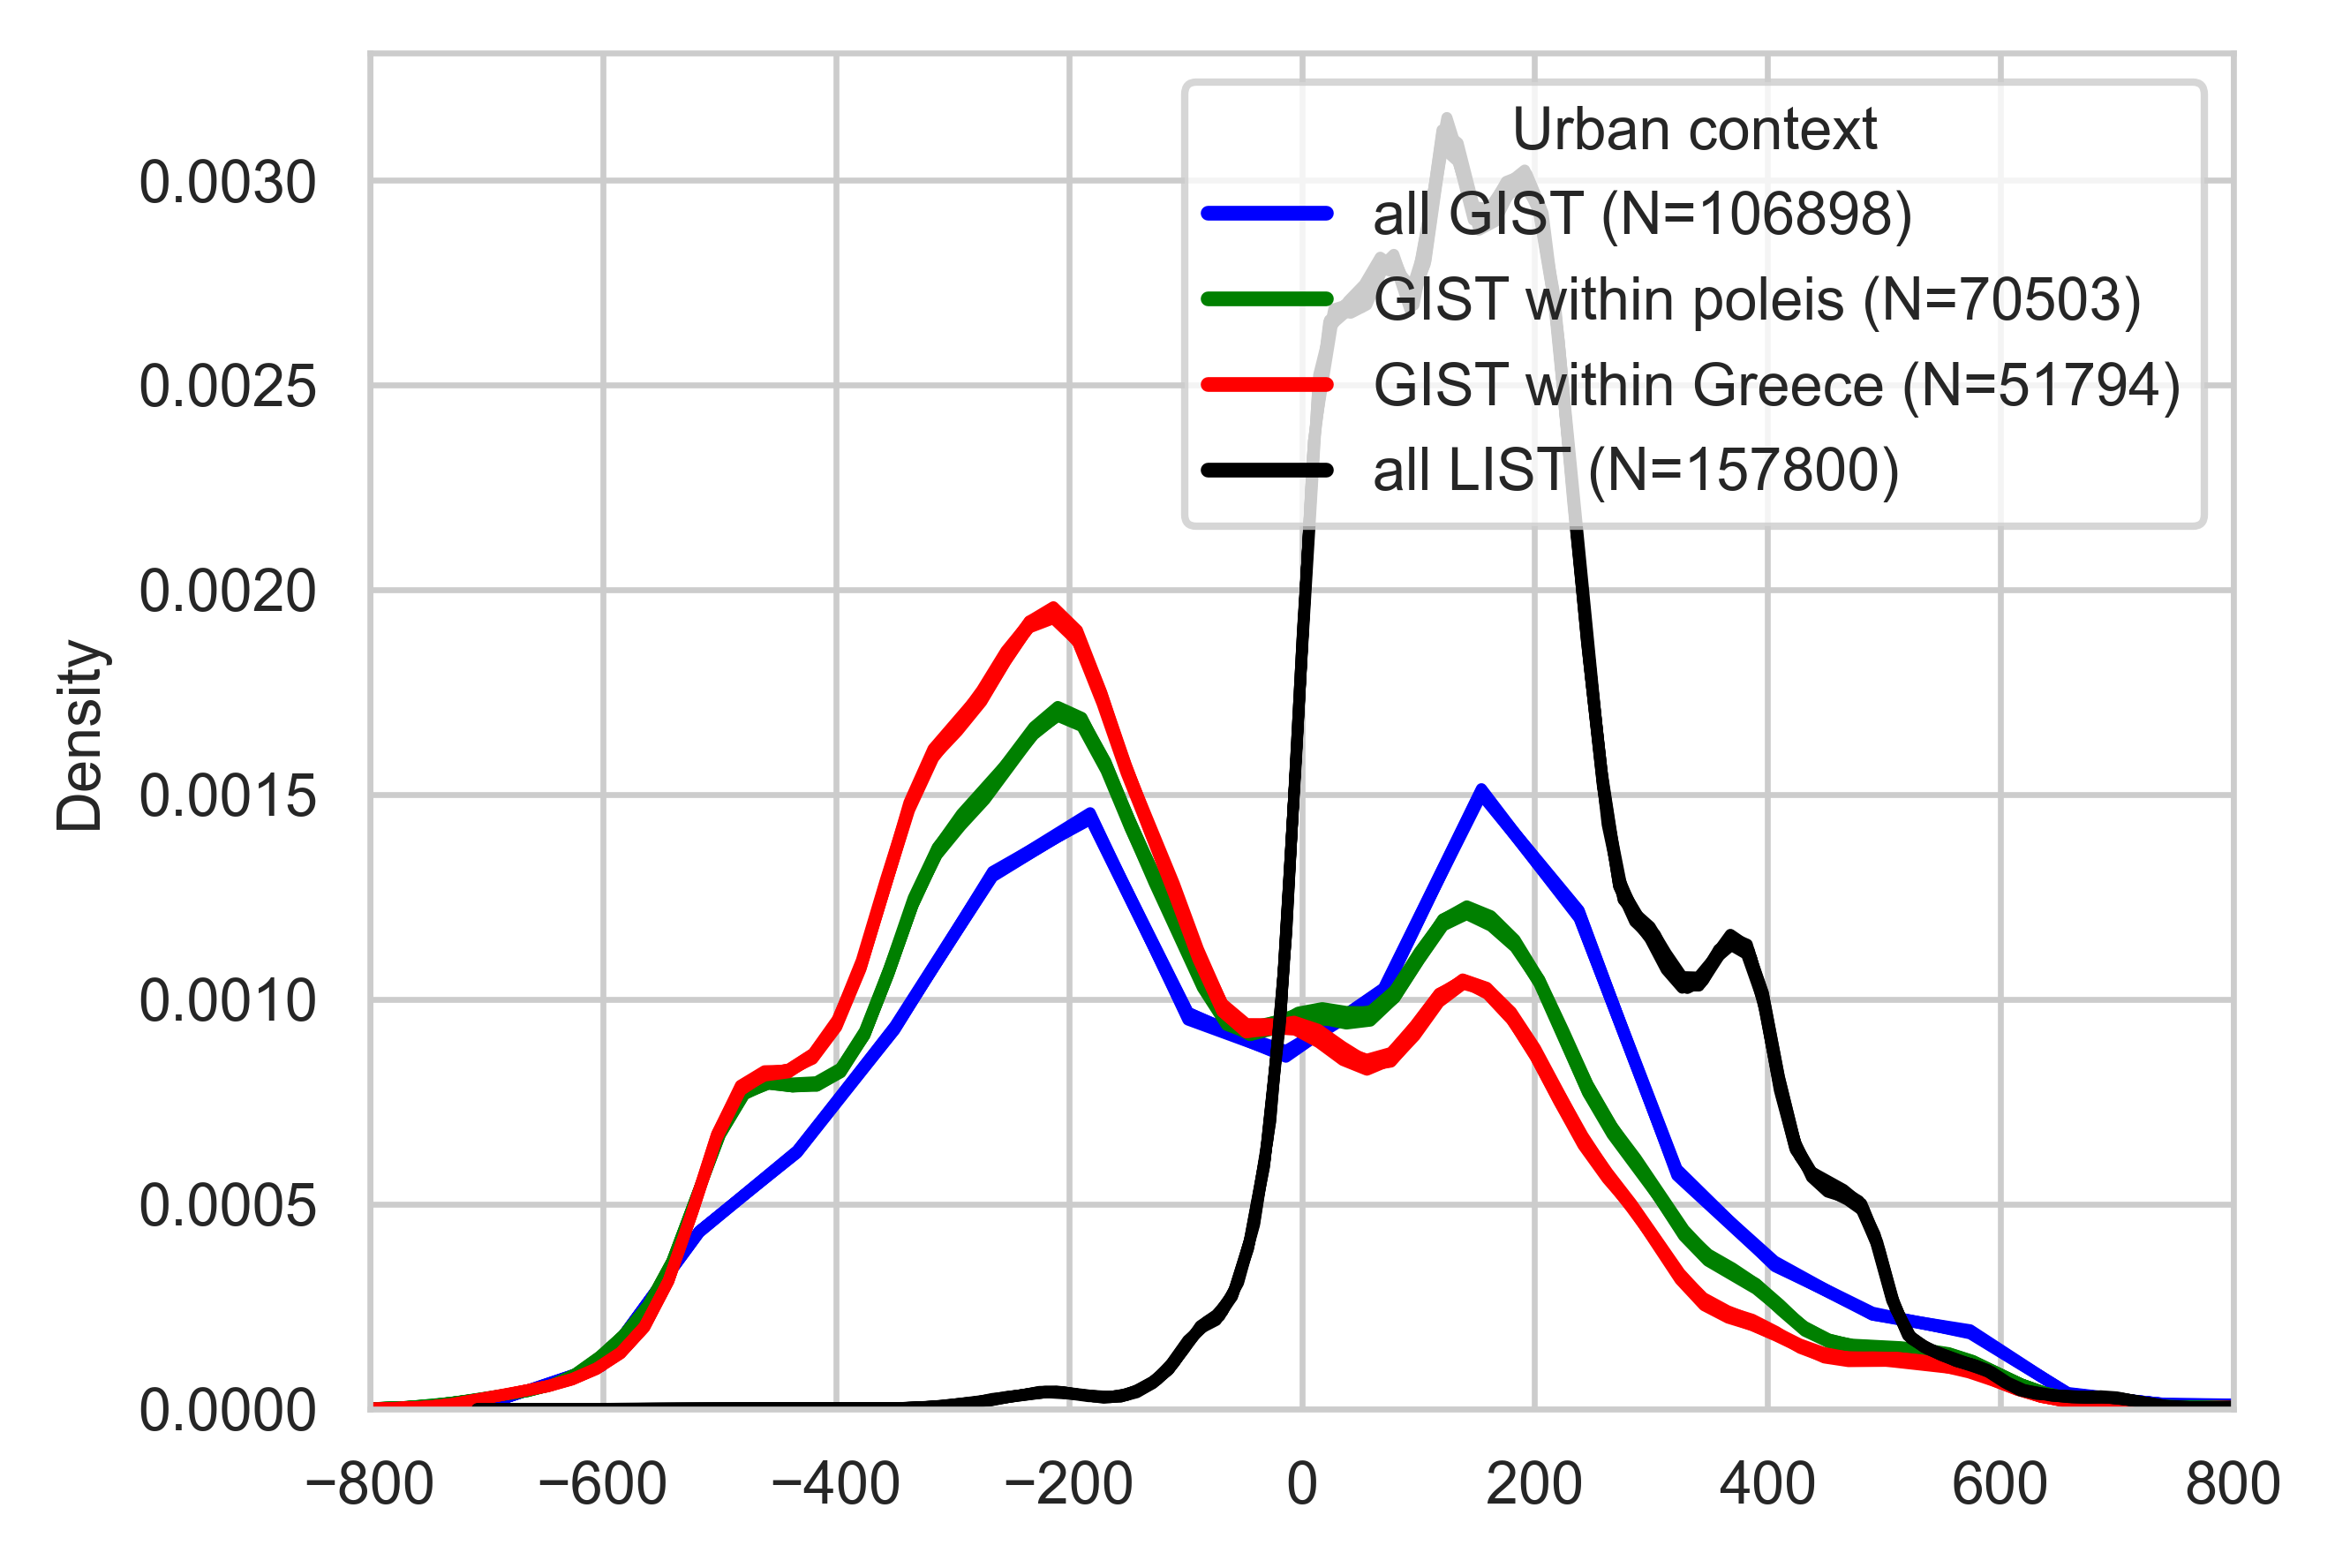

In [210]:
fig, ax = plt.subplots(tight_layout=True)
tempun.kdeplot_from_randoms(GIST["random_dates"], ax=ax,color="blue", random_size=10)
tempun.kdeplot_from_randoms(GIST[GIST["polis?"]]["random_dates"], ax=ax, color="green", random_size=10)
tempun.kdeplot_from_randoms(GIST[GIST["greece?"]]["random_dates"], ax=ax, color="red", random_size=10)
tempun.kdeplot_from_randoms(LIST["random_dates"], ax=ax, color="black", random_size=10)
ax.set_xlim(-800,800)

legend_labels = ["all GIST (N={})".format(str(len(GIST))),
                 "GIST within poleis (N={})".format(str(sum(GIST["polis?"]))),
                 "GIST within Greece (N={})".format(str(sum(GIST["greece?"]))),
                 "all LIST (N={})".format(str(len(LIST)))]
colors=["blue", "green", "red", "black"]
markers = [plt.Line2D([0,0],[0,0],color=color, lw=2) for color in colors]
ax.legend(markers, legend_labels, numpoints=1,  title="Urban context", bbox_to_anchor=(1, 1), loc='upper right')

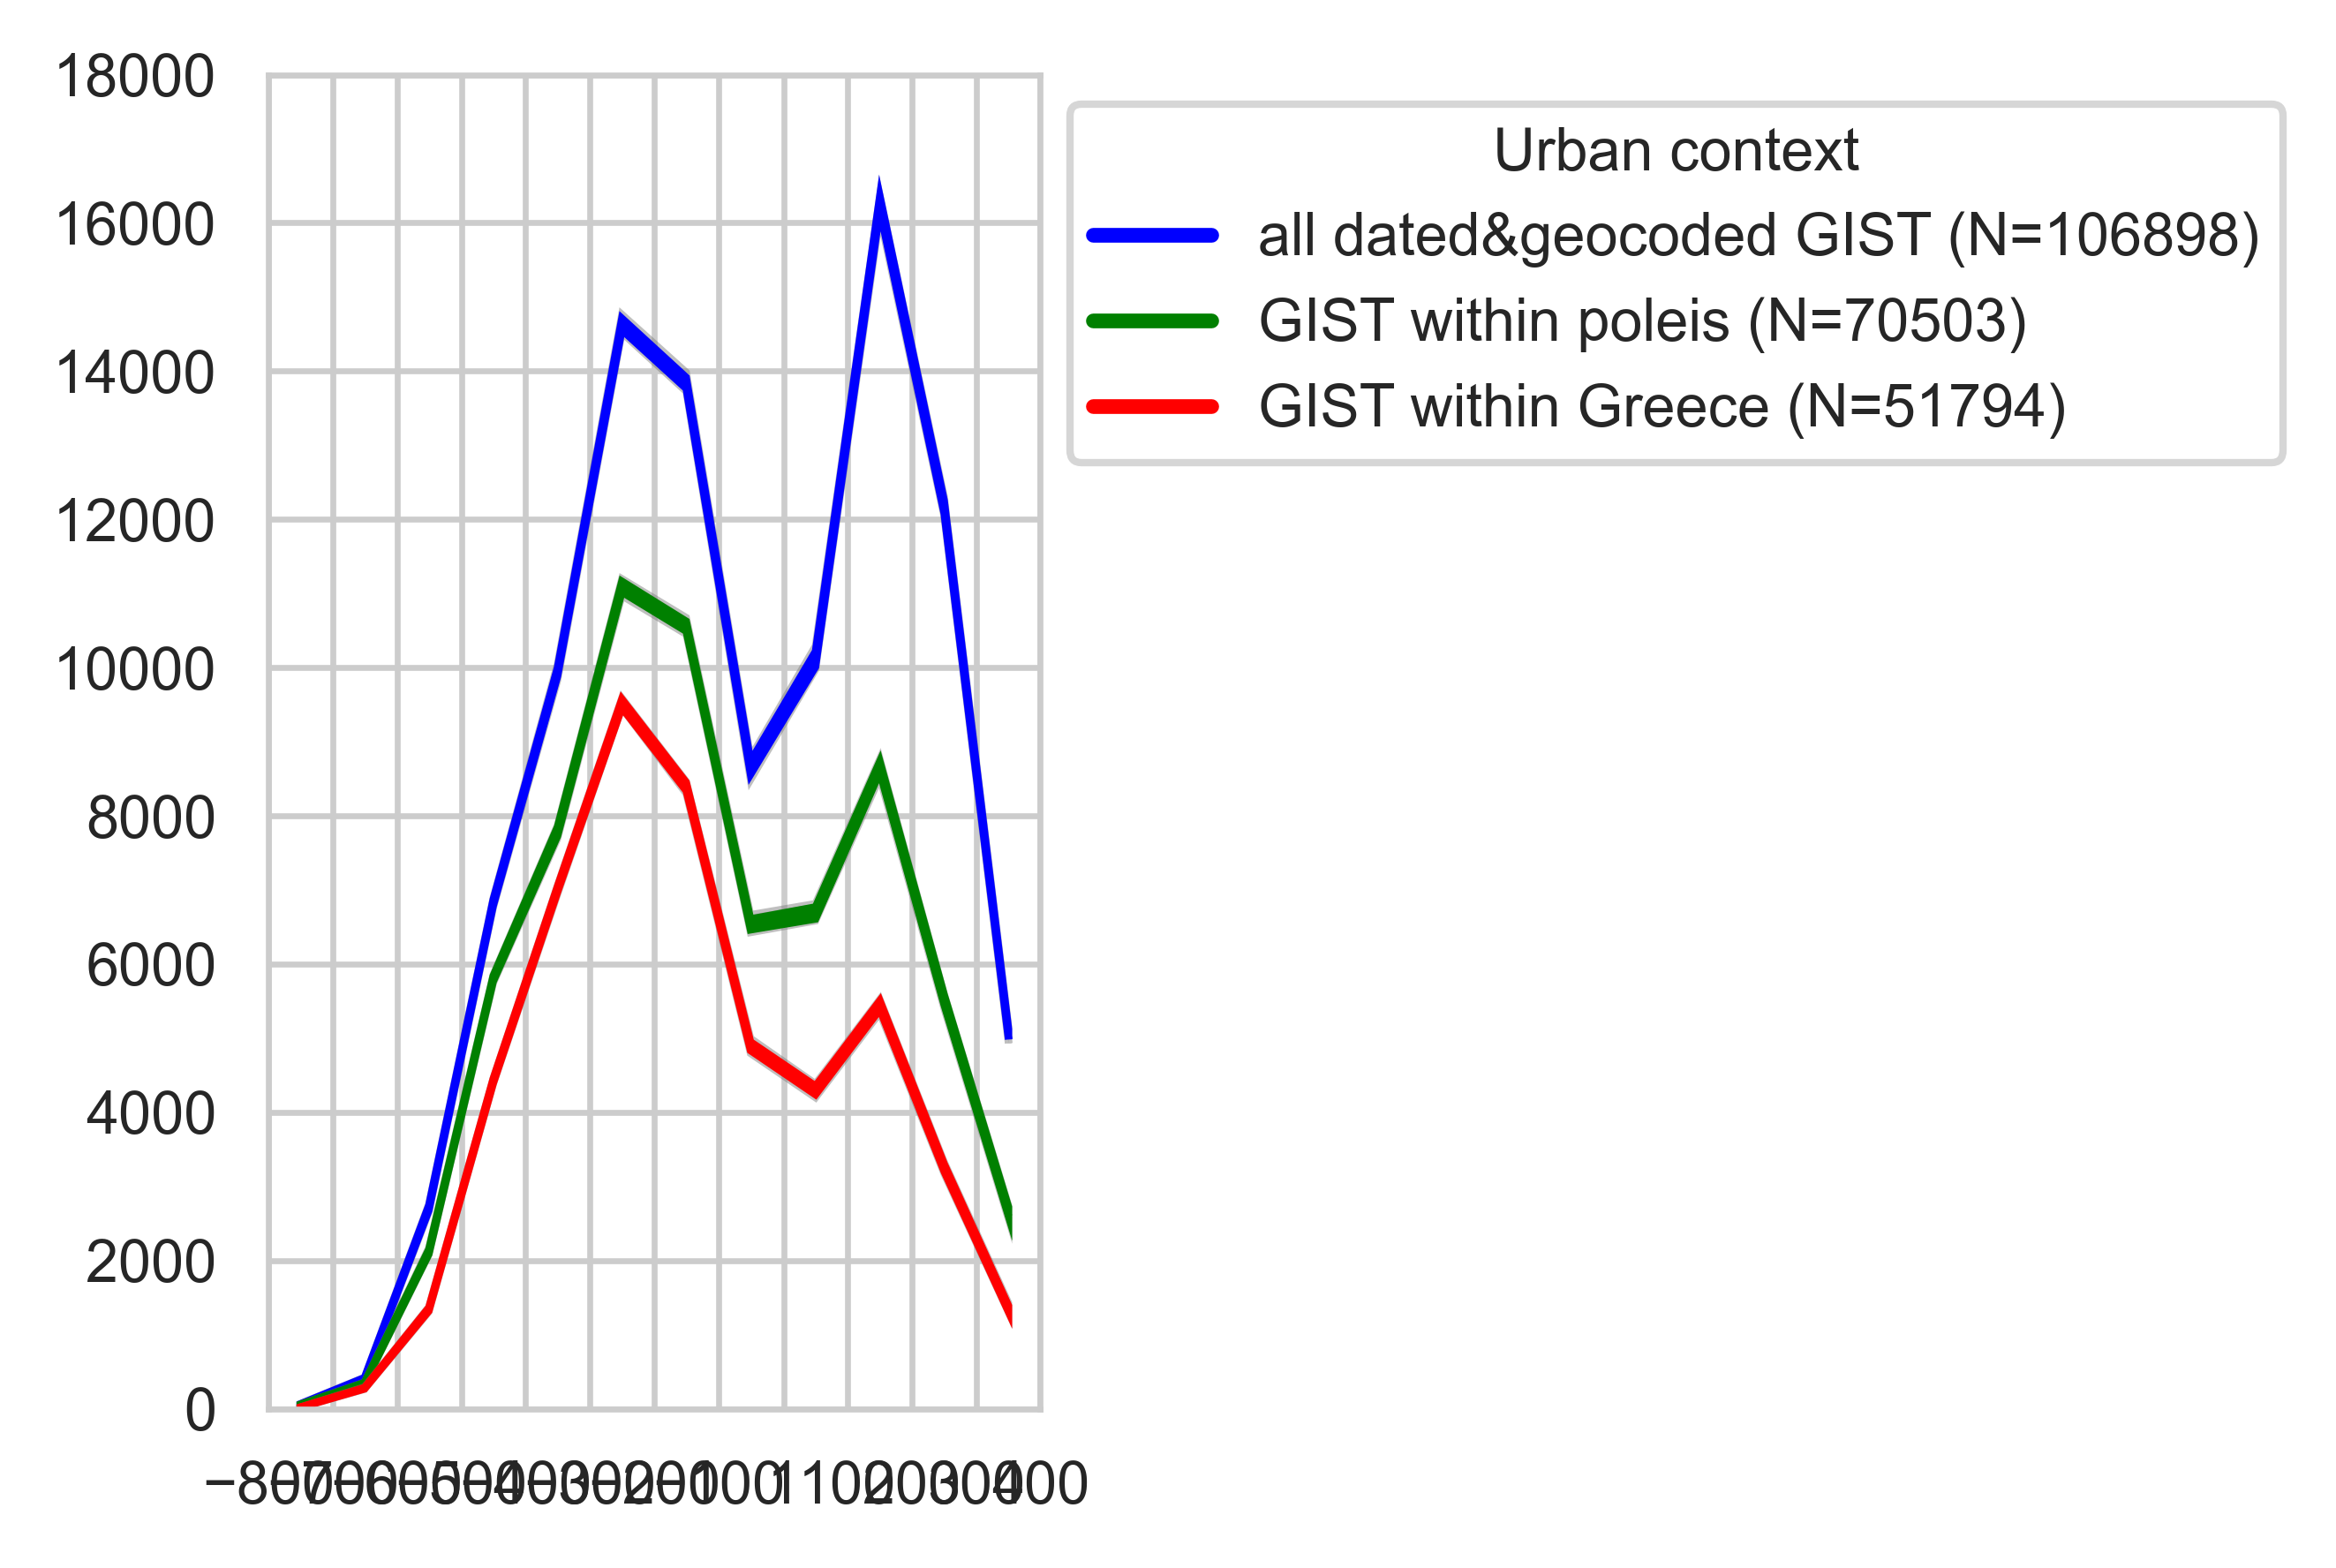

In [212]:
fig, ax = plt.subplots(tight_layout=True)
random_size=100
tempun.timeblocksplot_from_randoms(GIST["random_dates"], ax=ax,color="blue", timeblocks=[-800,400,100], random_size=random_size)
tempun.timeblocksplot_from_randoms(GIST[GIST["polis?"]]["random_dates"], ax=ax, color="green", timeblocks=[-800,400,100], random_size=random_size)
tempun.timeblocksplot_from_randoms(GIST[GIST["greece?"]]["random_dates"], ax=ax, color="red", timeblocks=[-800,400,100], random_size=random_size)
#tempun.timeblocksplot_from_randoms(LIST["random_dates"], ax=ax, color="darkgrey", timeblocks=[-800,400,100], random_size=10)
ax.set_xlim(-800,400)
ax.set_ylim(0,18000)
ax.set_xticks([el+1 if el==0 else el for el in range(-800,500,100)])


legend_labels = ["all dated&geocoded GIST (N={})".format(str(len(GIST))),
                 "GIST within poleis (N={})".format(str(sum(GIST["polis?"]))),
                 "GIST within Greece (N={})".format(str(sum(GIST["greece?"])))]
                 #"all LIST (N={})".format(str(len(LIST)))]
colors=["blue", "green", "red"] #, "darkgrey"]
markers = [plt.Line2D([0,0],[0,0],color=color, lw=2) for color in colors]
ax.legend(markers, legend_labels, numpoints=1,  title="Urban context", bbox_to_anchor=(1, 1), loc='upper left')

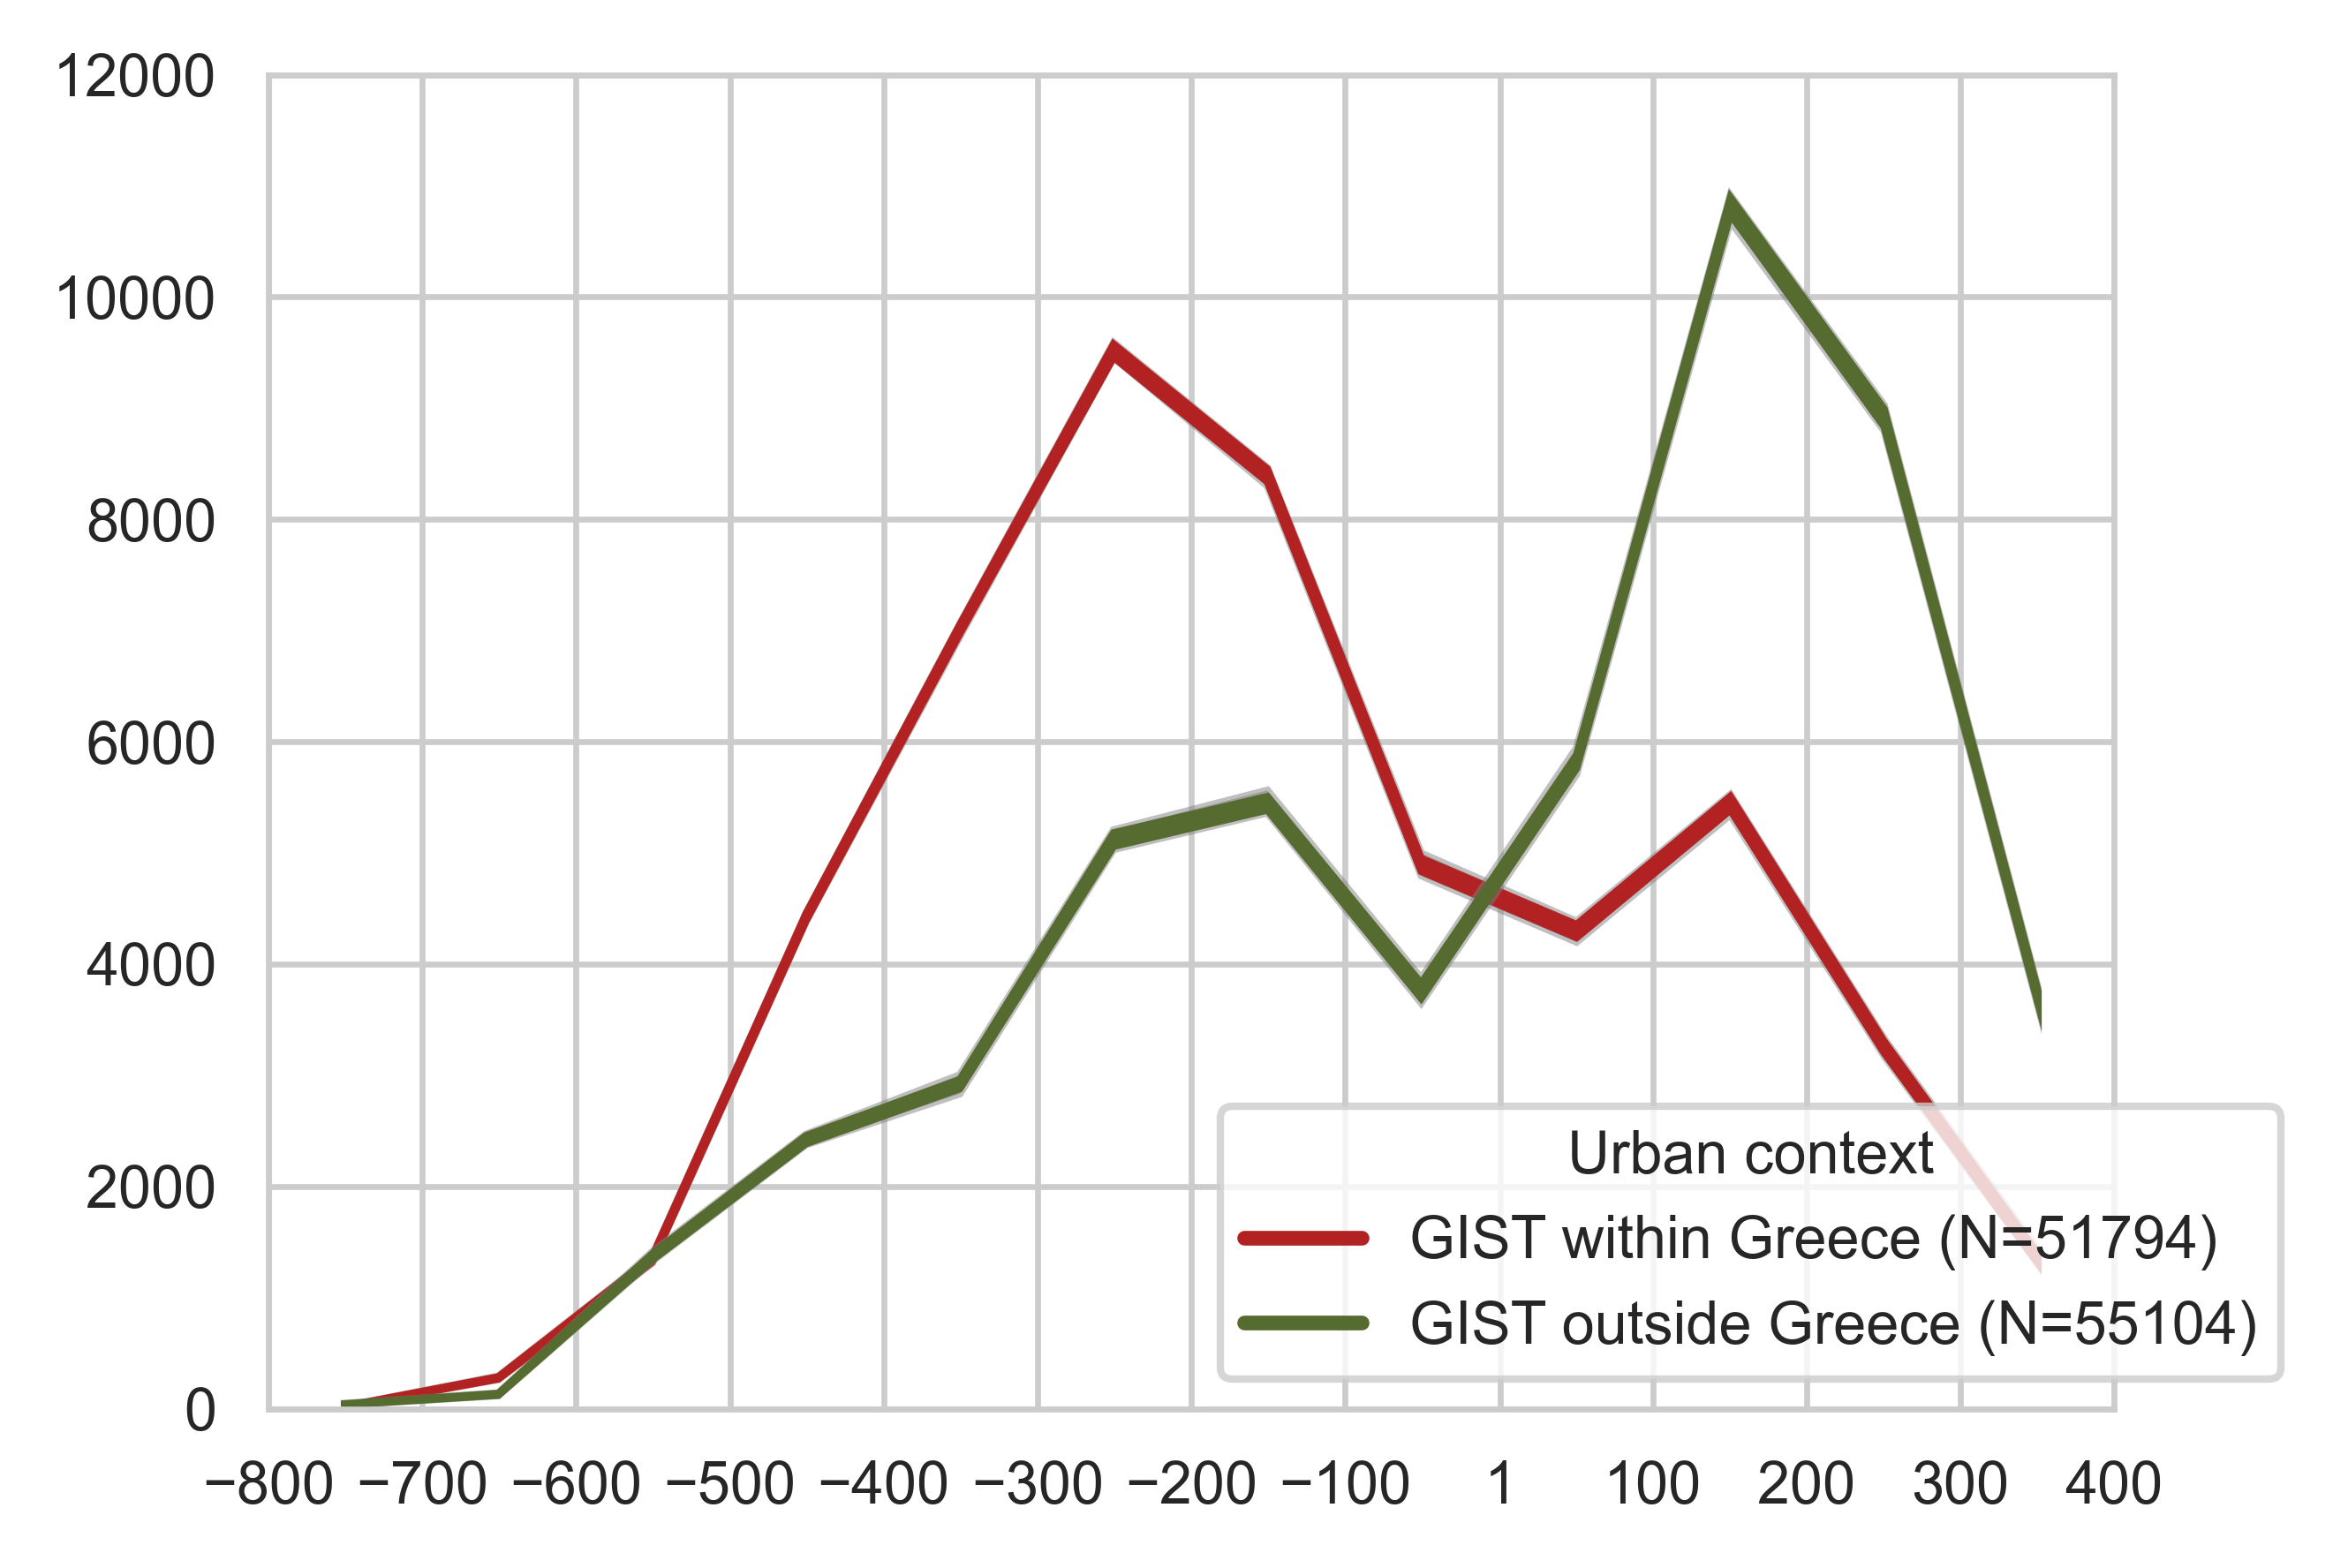

In [213]:
fig, ax = plt.subplots(tight_layout=True)
random_size=100
tempun.timeblocksplot_from_randoms(GIST[GIST["greece?"]]["random_dates"], ax=ax, color="firebrick", timeblocks=[-800,400,100], random_size=random_size)
tempun.timeblocksplot_from_randoms(GIST[~GIST["greece?"]]["random_dates"], ax=ax, color="darkolivegreen", timeblocks=[-800,400,100], random_size=random_size)
#tempun.timeblocksplot_from_randoms(LIST["random_dates"], ax=ax, color="darkgrey", timeblocks=[-800,400,100], random_size=10)
ax.set_xlim(-800,400)
ax.set_ylim(0,12000)
ax.set_xticks([el+1 if el==0 else el for el in range(-800,500,100)])


legend_labels = [
                 "GIST within Greece (N={})".format(str(sum(GIST["greece?"]))),
                 "GIST outside Greece (N={})".format(str(sum(~GIST["greece?"])))]
#"all LIST (N={})".format(str(len(LIST)))]
colors=["firebrick", "darkolivegreen"] #, "darkgrey"]
markers = [plt.Line2D([0,0],[0,0],color=color, lw=2) for color in colors]
ax.legend(markers, legend_labels, numpoints=1,  title="Urban context", bbox_to_anchor=(0.5, 0), loc='lower left')

In [214]:
data = []
for cent in range(-8, 4):
    if cent < 0:
        cent_start, cent_end = cent * 100, cent * 100 + 99
        cent_label = "{} BCE".format(str(abs(cent)))
    else:
        cent_start, cent_end = cent * 100 + 1, cent * 100 + 100
        cent_label = "{} CE".format(str(cent + 1))
    subset = GIST[GIST["random_dates"].apply(lambda x: cent_start < x[0] < cent_end)]
    words_N = sum(subset["clean_text_interpretive_word"].apply(lambda x: len(x.split())))
    data.append({"cent_raw": cent,  "cent_label" : cent_label, "inscr_N" : len(subset), "words_N" : words_N})

In [215]:
cent_overview = pd.DataFrame(data)
cent_overview

cent_raw cent_label  inscr_N  words_N
0         -8      8 BCE       57      259
1         -7      7 BCE      405     2121
2         -6      6 BCE     2579    15159
3         -5      5 BCE     6690    68950
4         -4      4 BCE     9629   278518
5         -3      3 BCE    14184   488942
6         -2      2 BCE    13554   639027
7         -1      1 BCE     8397   200482
8          0       1 CE     9893   183330
9          1       2 CE    15928   323023
10         2       3 CE    11943   216615
11         3       4 CE     4969    66682

In [216]:
for n in range(len(cent_overview)):
    x, y, label = cent_overview.iloc[n]["cent_raw"], cent_overview.iloc[n]["inscr_N"], str(cent_overview.iloc[n]["inscr_N"])
    print(x, y, label)

-8 57 57
-7 405 405
-6 2579 2579
-5 6690 6690
-4 9629 9629
-3 14184 14184
-2 13554 13554
-1 8397 8397
0 9893 9893
1 15928 15928
2 11943 11943
3 4969 4969


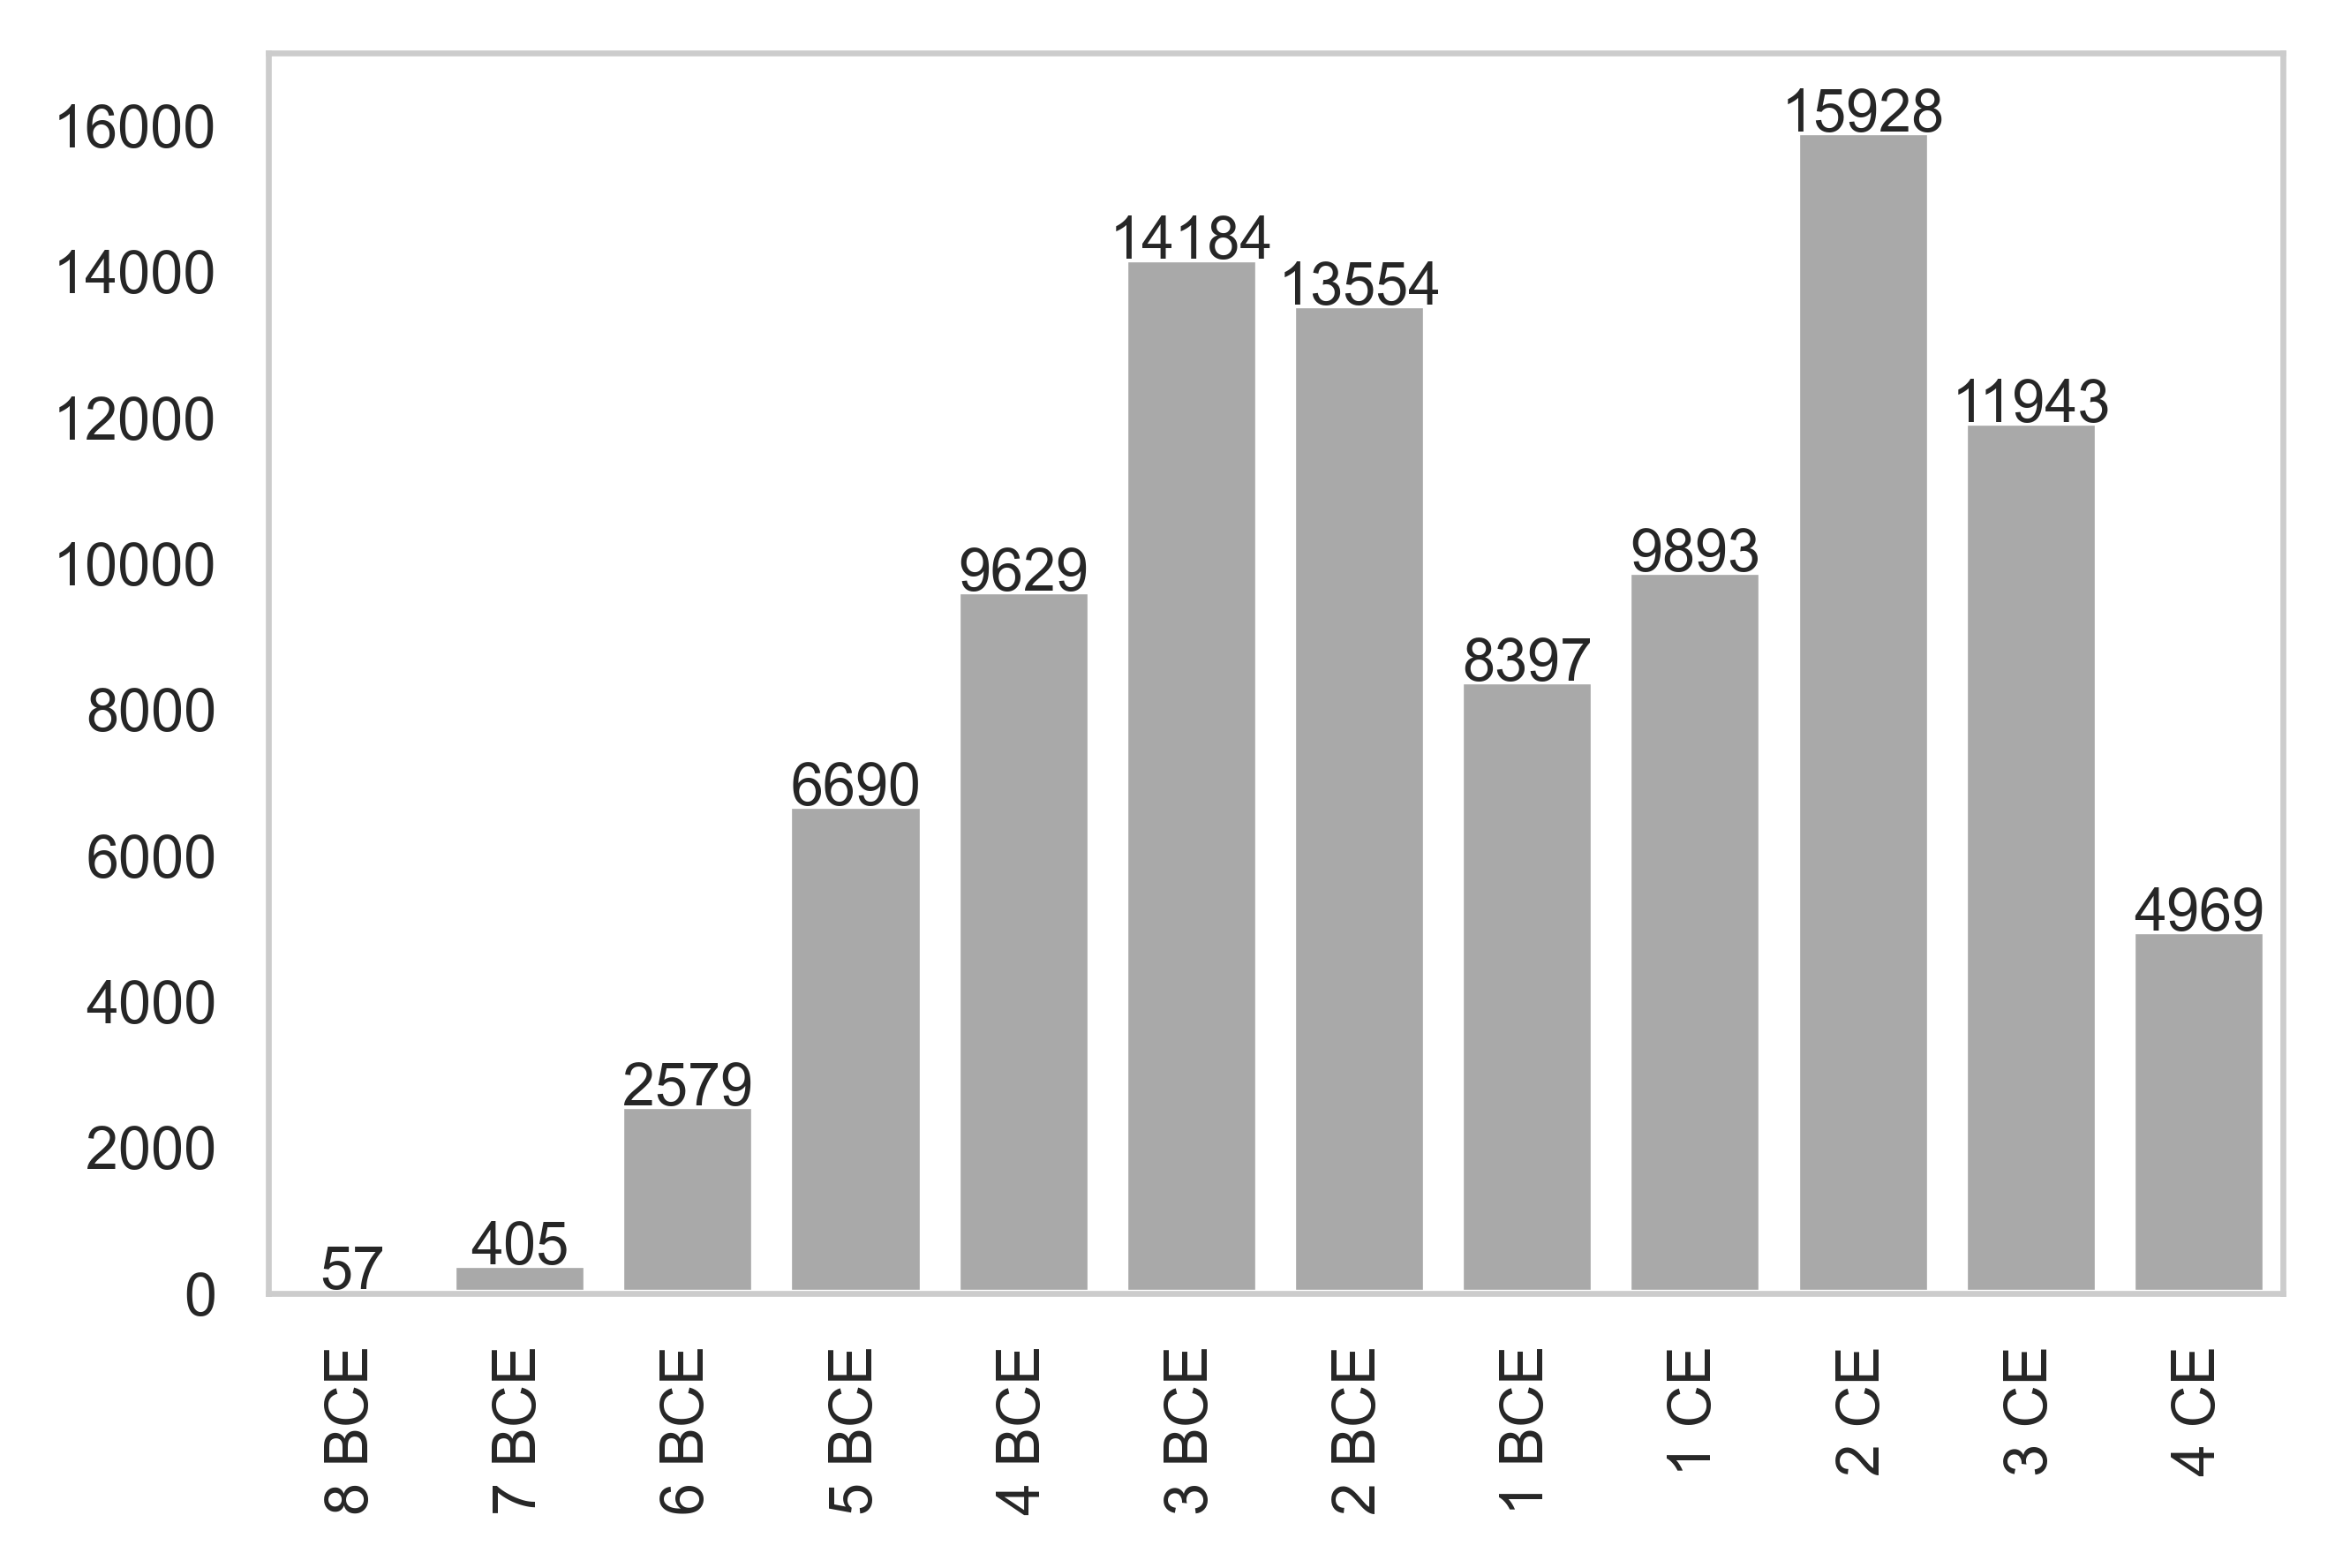

In [218]:
fig, ax = plt.subplots(tight_layout=True)
ax.bar(cent_overview["cent_raw"], cent_overview["inscr_N"], color="darkgrey")
ax.set_xlim(-8.5,3.5)
ax.set_ylim(0,17000)
ax.set_xticks(cent_overview["cent_raw"])
ax.set_xticklabels(cent_overview["cent_label"], rotation=90)
for n in range(len(cent_overview)):
    x, y, label = cent_overview.iloc[n]["cent_raw"], cent_overview.iloc[n]["inscr_N"], str(cent_overview.iloc[n]["inscr_N"])
    ax.text(x=x, y=y, s=label, horizontalalignment="center")
ax.grid(False)

In [219]:
save_figure(fig, "GIST_temporal_bars")

In [43]:
#!mkdir ../data/large_files
GIST.to_parquet("../data/large_files/GIST_geocontexts.parquet")